In [1]:
import torch
import scanpy as sc
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import dijkstra
from scipy.sparse import csr_matrix, issparse
from sklearn.preprocessing import normalize
import ot 
from sklearn.neighbors import NearestNeighbors

In [2]:
def construct_graph_torch(X, k, mode='connectivity', metric = 'minkowski', p=2, device='cuda'):
    '''construct knn graph with torch and gpu
    args:
        X: input data containing features (torch tensor)
        k: number of neighbors for each data point
        mode: 'connectivity' or 'distance'
        metric: distance metric (now euclidean supported for gpu knn)
        p: param for minkowski (not used if metric is euclidean)
    
    Returns:
        knn graph as a pytorch sparse tensor (coo format) or dense tensor depending on mode     
    '''

    assert mode in ['connectivity', 'distance'], "mode must be 'connectivity' or 'distance'."
    assert metric == 'euclidean', "for gpu knn, only 'euclidean' metric is currently supported in this implementation"

    if mode == 'connectivity':
        include_self = True
        mode_knn = 'connectivity'
    else:
        include_self = False
        mode_knn = 'distance'

    n_samples = X.shape[0]
    knn = NearestNeighbors(n_neighbors=k, metric=metric, algorithm='auto')

    if device == 'cuda' and torch.cuda.is_available():
        X_cpu = X.cpu().numpy()
    else:
        X_cpu = X.numpy()

    knn.fit(X_cpu)
    knn_graph_cpu = kneighbors_graph(knn, k, mode=mode_knn, include_self=include_self, metric=metric) #scipy sparse matrix on cpu
    knn_graph_coo = knn_graph_cpu.tocoo()

    if mode == 'connectivity':
        knn_graph = torch.sparse_coo_tensor(torch.LongTensor([knn_graph_coo.row, knn_graph_coo.col]),
                                            torch.FloatTensor(knn_graph_coo.data),
                                            size = knn_graph_coo.shape).to(device)
    elif mode == 'distance':
        knn_graph_dense = torch.tensor(knn_graph_cpu.toarray(), dtype=torch.float32, device=device) #move to gpu as dense tensor
        knn_graph = knn_graph_dense
    
    return knn_graph
    
def distances_cal_torch(graph, type_aware=None, aware_power =2, device='cuda'):
    '''
    calculate distance matrix from graph using dijkstra's algo
    args:
        graph: knn graph (pytorch sparse or dense tensor)
        type_aware: not implemented in this torch version for simplicity
        aware_power: same ^^
        device (str): 'cpu' or 'cuda' device to use
    Returns:
        distance matrix as a torch tensor
    '''

    if isinstance(graph, torch.Tensor) and graph.is_sparse:
        graph_cpu_csr = csr_matrix(graph.cpu().to_dense().numpy())
    elif isinstance(graph, torch.Tensor) and not graph.is_sparse:
        graph_cpu_csr = csr_matrix(graph.cpu().numpy())
    else:
        graph_cpu_csr = csr_matrix(graph) #assume scipy sparse matrix if not torch tensor

    shortestPath_cpu = dijkstra(csgraph = graph_cpu_csr, directed=False, return_predecessors=False) #dijkstra on cpu
    shortestPath = torch.tensor(shortestPath_cpu, dtype=torch.float32, device=device)

    # the_max = torch.nanmax(shortestPath[shortestPath != float('inf')])
    # shortestPath[shortestPath > the_max] = the_max

    #mask out infinite distances
    mask = shortestPath != float('inf')
    if mask.any():
        the_max = torch.max(shortestPath[mask])
        shortestPath[~mask] = the_max #replace inf with max value
    else:
        the_max = 1.0 #fallback if all are inf (should not happen in connected graphs)

    C_dis = shortestPath / the_max
    C_dis -= torch.mean(C_dis)
    return C_dis

def calculate_D_sc_torch(X_sc, k_neighbors=10, graph_mode='connectivity', device='cpu'):
    '''calculate distance matrix from graph using dijkstra's algo
    args:
        graph: knn graph (torch sparse or dense tensor)
        type_aware: not implemented
        aware_power: same ^^
        
    returns:
        distanced matrix as torch tensor'''
    
    if not isinstance(X_sc, torch.Tensor):
        raise TypeError('Input X_sc must be a pytorch tensor')
    
    if device == 'cuda' and torch.cuda.is_available():
        X_sc = X_sc.cuda(device=device)
    else:
        X_sc = X_sc.cpu()
        device= 'cpu'

    print(f'using device: {device}')
    print(f'constructing knn graph...')
    # X_normalized = normalize(X_sc.cpu().numpy(), norm='l2') #normalize on cpu for sklearn knn
    X_normalized = X_sc
    X_normalized_torch = torch.tensor(X_normalized, dtype=torch.float32, device=device)

    Xgraph = construct_graph_torch(X_normalized_torch, k=k_neighbors, mode=graph_mode, metric='euclidean', device=device)

    print('calculating distances from graph....')
    D_sc = distances_cal_torch(Xgraph, device=device)

    print('D_sc calculation complete')
    
    return D_sc


In [3]:
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from scipy.sparse.csgraph import dijkstra
from scipy.sparse import csr_matrix, issparse
from sklearn.preprocessing import normalize
import ot

def construct_graph_spatial(location_array, k, mode='distance', metric='euclidean', p=2):
    '''construct KNN graph based on spatial coordinates
    args:
        location_array: spatial coordinates of spots (n-spots * 2)
        k: number of neighbors for each spot
        mode: 'connectivity' or 'distance'
        metric: distance metric for knn (p=2 is euclidean)
        p: param for minkowski if connectivity
        
    returns:
        scipy.sparse.csr_matrix: knn graph in csr format
    '''

    assert mode in ['connectivity', 'distance'], "mode must be 'connectivity' or 'distance'"
    if mode == 'connectivity':
        include_self = True
    else:
        include_self = False
    
    c_graph = kneighbors_graph(location_array, k, mode=mode, metric=metric, include_self=include_self, p=p)
    return c_graph

def distances_cal_spatial(graph, spot_ids=None, spot_types=None, aware_power=2):
    '''calculate spatial distance matrix from knn graph
    args:
        graph (scipy.sparse.csr_matrix): knn graph
        spot_ids (list, optional): list of spot ids corresponding to the rows/cols of the graph. required if type_aware is used
        spot_types (pd.Series, optinal): pandas series of spot types for type aware distance adjustment. required if type_aware is used
        aware_power (int): power for type-aware distance adjustment
        
    returns:
        sptial distance matrix'''
    shortestPath = dijkstra(csgraph = csr_matrix(graph), directed=False, return_predecessors=False)
    shortestPath = np.nan_to_num(shortestPath, nan=np.inf) #handle potential inf valyes after dijkstra

    if spot_types is not None and spot_ids is not None:
        shortestPath_df = pd.DataFrame(shortestPath, index=spot_ids, columns=spot_ids)
        shortestPath_df['id1'] = shortestPath_df.index
        shortestPath_melted = shortestPath_df.melt(id_vars=['id1'], var_name='id2', value_name='value')

        type_aware_df = pd.DataFrame({'spot': spot_ids, 'spot_type': spot_types}, index=spot_ids)
        meta1 = type_aware_df.copy()
        meta1.columns = ['id1', 'type1']
        meta2 = type_aware_df.copy()
        meta2.columns = ['id2', 'type2']

        shortestPath_melted = pd.merge(shortestPath_melted, meta1, on='id1', how='left')
        shortestPath_melted = pd.merge(shortestPath_melted, meta2, on='id2', how='left')

        shortestPath_melted['same_type'] = shortestPath_melted['type1'] == shortestPath_melted['type2']
        shortestPath_melted.loc[(~shortestPath_melted.smae_type), 'value'] = shortestPath_melted.loc[(~shortestPath_melted.same_type),
                                                                                                     'value'] * aware_power
        shortestPath_melted.drop(['type1', 'type2', 'same_type'], axis=1, inplace=True)
        shortestPath_pivot = shortestPath_melted.pivot(index='id1', columns='id2', values='value')

        order = spot_ids
        shortestPath = shortestPath_pivot[order].loc[order].values
    else:
        shortestPath = np.asarray(shortestPath) #ensure it's a numpy array

    #mask out infinite distances
    mask = shortestPath != float('inf')
    if mask.any():
        the_max = np.max(shortestPath[mask])
        shortestPath[~mask] = the_max #replace inf with max value
    else:
        the_max = 1.0 #fallback if all are inf (should not happen in connected graphs)

    C_dis = shortestPath / the_max
    C_dis -= np.mean(C_dis)

    return C_dis

def calculate_D_st_from_coords(spatial_coords, X_st=None, k_neighbors=10, graph_mode='distance', aware_st=False, 
                               spot_types=None, aware_power_st=2, spot_ids=None):
    '''calculates the spatial distance matrix D_st for spatial transcriptomics data directly from coordinates and optional spot types
    args:
        spatial_coords: spatial coordinates of spots (n_spots * 2)
        X_st: St gene expression data (not used for D_st calculation itself)
        k_neighbors: number of neighbors for knn graph
        graph_mode: 'connectivity or 'distance' for knn graph
        aware_st: whether to use type-aware distance adjustment
        spot_types: pandas series of spot types for type-aware adjustment
        aware_power_st: power for type-aware distance adjustment
        spot_ids: list or index of spot ids, required if spot_ids is provided
        
    returns:
        np.ndarray: spatial disance matrix D_st'''
    
    if isinstance(spatial_coords, pd.DataFrame):
        location_array = spatial_coords.values
        if spot_ids is None:
            spot_ids = spatial_coords.index.tolist() #use index of dataframe if available
    elif isinstance(spatial_coords, np.ndarray):
        location_array = spatial_coords
        if spot_ids is None:
            spot_ids = list(range(location_array.shape[0])) #generate default ids if not provided

    else:
        raise TypeError('spatial_coords must be a pandas dataframe or a numpy array')
    
    print(f'constructing {graph_mode} graph for ST data with k={k_neighbors}.....')
    Xgraph_st = construct_graph_spatial(location_array, k=k_neighbors, mode=graph_mode)
    
    if aware_st:
        if spot_types is None or spot_ids is None:
            raise ValueError('spot_types and spot_ids must be provided when aware_st=True')
        if not isinstance(spot_types, pd.Series):
            spot_types = pd.Series(spot_types, idnex=spot_ids) 
        print('applying type aware distance adjustment for ST data')
        print(f'aware power for ST: {aware_power_st}')
    else:
        spot_types = None 

    print(f'calculating spatial distances.....')
    D_st = distances_cal_spatial(Xgraph_st, spot_ids=spot_ids, spot_types=spot_types, aware_power=aware_power_st)

    print('D_st calculation complete')
    return D_st


In [4]:
def fused_gw_torch(X_sc, X_st, Y_st, alpha, k=100, G0=None, max_iter = 100, tol=1e-9, device='cuda', n_iter = 1):
    n = X_sc.shape[0]
    m = X_st.shape[0]

    X_sc = X_sc.to(device)
    X_st = X_st.to(device)

    if not torch.is_tensor(Y_st):
        Y_st_tensor = torch.tensor(Y_st, dtype=torch.float32, device=device)
    else:
        Y_st_tensor = Y_st.to(device, dtype=torch.float32)

    #calculate distance matrices
    print('calculating SC distances with knn-dijkstra.....')
    D_sc = calculate_D_sc_torch(X_sc, k_neighbors=k, device=device)

    print('Calculating ST distances.....')
    D_st = calculate_D_st_from_coords(spatial_coords=Y_st, k_neighbors=15, graph_mode="distance") # Using calculate_D_st_from_coords
    D_st = torch.tensor(D_st, dtype=torch.float32, device=device) # Convert D_st to tensor and move to device

    #get expression distance matrix
    C_exp = torch.cdist(X_sc, X_st, p=2) #euclidean distance
    C_exp = C_exp / (torch.max(C_exp) + 1e-16) #normalize

    #ensure distance matries are C-contiguouse numpy arrays for POT
    D_sc_np = D_sc.cpu().numpy()
    D_st_np = D_st.cpu().numpy()
    C_exp_np = C_exp.cpu().numpy()
    D_sc_np = np.ascontiguousarray(D_sc_np)
    D_st_np = np.ascontiguousarray(D_st_np)
    C_exp_np = np.ascontiguousarray(C_exp_np)

    #uniform distributions
    p = ot.unif(n)
    q = ot.unif(m)

    #anneal the reg param over several steps
    T_np = None
    for i in range(n_iter):
        #run fused gw with POT
        T_np, log = ot.gromov.fused_gromov_wasserstein(
            M=C_exp_np, C1=D_sc_np, C2=D_st_np,
            p=p, q=q, loss_fun='square_loss',
            alpha=alpha,
            G0=T_np if T_np is not None else (G0.cpu().numpy() if G0 is not None else None),
            log=True,
            verbose=True,
            max_iter = max_iter,
            tol_abs=tol
        )

    fgw_dist = log['fgw_dist']

    print(f'fgw distance: {fgw_dist}')

    T = torch.tensor(T_np, dtype=torch.float32, device=device)

    return T, D_sc, D_st, fgw_dist

In [5]:
scdata = pd.read_csv('./data/mousedata_2020/E1z2/simu_sc_counts.csv',index_col=0)
scdata = scdata.T
stdata = pd.read_csv('data/mousedata_2020/E1z2/simu_st_counts.csv',index_col=0)
stdata = stdata.T
stgtcelltype = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_celltype.csv',index_col=0)
spcoor = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_metadata.csv',index_col=0)
scmetadata = pd.read_csv('./data/mousedata_2020/E1z2/metadata.csv',index_col=0)

adata = sc.AnnData(scdata,obs=scmetadata)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
scdata = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata = pd.DataFrame(stadata.X,index=stadata.obs_names,columns=stadata.var_names)

adata.obsm['spatial'] = scmetadata[['x_global','y_global']].values
stadata.obsm['spatial'] = spcoor

# Preprocess data (normalize, log transform)
adata = sc.AnnData(scdata, obs=scmetadata)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
scdata_processed = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
X_sc = torch.tensor(scdata_processed.values, dtype=torch.float32)

stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata_processed = pd.DataFrame(stadata.X, index=stadata.obs_names, columns=stadata.var_names)
X_st = torch.tensor(stdata_processed.values, dtype=torch.float32)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Y_st = spcoor.values
# --- Run FGW using POT ---
T, D_sc, D_st, fgw_dist = fused_gw_torch(
    X_sc=X_sc, X_st=X_st, Y_st=Y_st,
    alpha=0.3, # Example: balance expression and structure equally
    k=300,      # k for SC graph
    max_iter=200,
    device=device
)

calculating SC distances with knn-dijkstra.....
using device: cuda
constructing knn graph...


/tmp/ipykernel_3685606/1510132338.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_normalized_torch = torch.tensor(X_normalized, dtype=torch.float32, device=device)
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may han

calculating distances from graph....
D_sc calculation complete
Calculating ST distances.....
constructing distance graph for ST data with k=15.....
calculating spatial distances.....
D_st calculation complete
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.111893e-01|0.000000e+00|0.000000e+00


/home/ehtesamul/miniconda3/envs/ehtesamenv_gains/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


    1|4.530629e-01|1.282964e-01|5.812633e-02
    2|4.530629e-01|0.000000e+00|0.000000e+00
fgw distance: 0.4530629189330607


In [7]:
D_st = D_st.to(device)
D_induced = T @ D_st @ T.t()
D_induced

tensor([[-3.9058e-09, -3.9058e-09, -3.4337e-09,  ...,  4.9544e-09,
          4.5306e-09,  4.3681e-09],
        [-3.9058e-09, -3.9058e-09, -3.4337e-09,  ...,  4.9544e-09,
          4.5306e-09,  4.3681e-09],
        [-3.4337e-09, -3.4337e-09, -3.9058e-09,  ...,  5.4266e-09,
          5.0028e-09,  4.7924e-09],
        ...,
        [ 4.9544e-09,  4.9544e-09,  5.4266e-09,  ..., -3.9058e-09,
         -3.3879e-09, -3.1976e-09],
        [ 4.5306e-09,  4.5306e-09,  5.0028e-09,  ..., -3.3879e-09,
         -3.9058e-09, -3.2460e-09],
        [ 4.3681e-09,  4.3681e-09,  4.7924e-09,  ..., -3.1976e-09,
         -3.2460e-09, -3.9058e-09]], device='cuda:0')

In [10]:
gt_sc_coords = np.column_stack([
    adata.obs['x_global'].values,
    adata.obs['y_global'].values
])

gt_sc_coords.shape

(10150, 2)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
from tqdm import tqdm
import os
import time
import scipy

class FeatureNet(nn.Module):
    def __init__(self, n_genes, n_embedding=[512, 256, 128], dp=0):
        super(FeatureNet, self).__init__()

        self.fc1 = nn.Linear(n_genes, n_embedding[0])
        self.bn1 = nn.LayerNorm(n_embedding[0])
        self.fc2 = nn.Linear(n_embedding[0], n_embedding[1])
        self.bn2 = nn.LayerNorm(n_embedding[1])
        self.fc3 = nn.Linear(n_embedding[1], n_embedding[2])
        
        self.dp = nn.Dropout(dp)
        
    def forward(self, x, isdp=False):
        if isdp:
            x = self.dp(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

class MMDLoss(nn.Module):
    def __init__(self, kernel_type='rbf', kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        super(MMDLoss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = fix_sigma
        self.kernel_type = kernel_type

    def guassian_kernel(self, source, target, kernel_mul, kernel_num, fix_sigma):
        n_samples = int(source.size()[0]) + int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i)
                          for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp)
                      for bandwidth_temp in bandwidth_list]
        tmp = 0
        for x in kernel_val:
            tmp += x
        return tmp

    def linear_mmd2(self, f_of_X, f_of_Y):
        loss = 0.0
        delta = f_of_X.float().mean(0) - f_of_Y.float().mean(0)
        loss = delta.dot(delta.T)
        return loss

    def forward(self, source, target):
        if self.kernel_type == 'linear':
            return self.linear_mmd2(source, target)
        elif self.kernel_type == 'rbf':
            batch_size = int(source.size()[0])
            kernels = self.guassian_kernel(
                source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
            XX = torch.mean(kernels[:batch_size, :batch_size])
            YY = torch.mean(kernels[batch_size:, batch_size:])
            XY = torch.mean(kernels[:batch_size, batch_size:])
            YX = torch.mean(kernels[batch_size:, :batch_size])
            loss = torch.mean(XX + YY - XY - YX)
            return loss

class SinusoidalEmbedding(nn.Module):
    """Sinusoidal embeddings for diffusion timesteps"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1, 0, 0))
        return emb

class STEMDiffusion:
    def __init__(
        self, 
        st_gene_expr,
        st_coords,
        D_st,
        sc_gene_expr,
        D_induced=None,
        outf='./diffusion_output',
        device='cuda',
        n_genes=None,
        n_embedding=[512, 256, 128],
        hidden_dim=256,
        dp=0.1,
        n_timesteps=800,
        beta_start=1e-4,
        beta_end=0.02,
        sigma=3.0,
        alpha=0.8,
        mmdbatch=1000,
        batch_size=256
    ):
        self.device = torch.device(device)
        
        # Create output directory
        self.outf = outf
        if not os.path.exists(outf):
            os.makedirs(outf)
        
        self.train_log = os.path.join(outf, 'train.log')
        
        # Store data
        self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
        self.st_coords = torch.tensor(st_coords, dtype=torch.float32).to(self.device)
        self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)
        
        # Store distance matrices
        self.D_st = torch.tensor(D_st, dtype=torch.float32).to(self.device)
        if D_induced is not None:
            self.D_induced = torch.tensor(D_induced, dtype=torch.float32).to(self.device)
        else:
            self.D_induced = None
        
        # Normalize coordinates for diffusion model
        coords_min = self.st_coords.min(dim=0)[0]
        coords_max = self.st_coords.max(dim=0)[0]
        coords_range = coords_max - coords_min
        self.st_coords_norm = 2 * (self.st_coords - coords_min) / coords_range - 1
        self.coords_min, self.coords_max = coords_min, coords_max
        self.coords_range = coords_range
        
        # STEM parameters
        self.n_genes = n_genes or st_gene_expr.shape[1]
        self.sigma = sigma
        self.alpha = alpha
        self.mmdbatch = mmdbatch
        self.batch_size = batch_size
        
        # Initialize feature encoder (shared between ST and SC data)
        self.netE = FeatureNet(self.n_genes, n_embedding=n_embedding, dp=dp).to(self.device)
        
        # Initialize diffusion model components
        
        # Time embedding
        self.time_embed = nn.Sequential(
            SinusoidalEmbedding(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        ).to(self.device)
        
        # Coordinate encoder
        self.coord_encoder = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        ).to(self.device)
        
        # Feature to hidden projection
        self.feat_proj = nn.Sequential(
            nn.Linear(n_embedding[-1], hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        ).to(self.device)

        #coordinate head to get coords direct from gene expression
        self.coord_head = nn.Sequential(
            nn.Linear(n_embedding[-1], hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 2)
        ).to(self.device)
        
        # Main network blocks
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU()
            ).to(self.device) for _ in range(4)
        ])
        
        # Output layer
        self.final = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.SiLU(),
            nn.Linear(hidden_dim//2, 2)
        ).to(self.device)
        
        # Setup optimizers and losses
        self.optimizer_E = torch.optim.AdamW(self.netE.parameters(), lr=0.002)
        self.scheduler_E = lr_scheduler.StepLR(optimizer=self.optimizer_E, step_size=200, gamma=0.5)
        
        diffusion_params = list(self.time_embed.parameters()) + \
                           list(self.coord_encoder.parameters()) + \
                           list(self.feat_proj.parameters()) + \
                           list(self.blocks.parameters()) + \
                           list(self.final.parameters())
        
        self.optimizer_diff = torch.optim.AdamW(diffusion_params, lr=1e-4, weight_decay=1e-6)
        self.scheduler_diff = lr_scheduler.CosineAnnealingLR(self.optimizer_diff, T_max=3000, eta_min=1e-6)
        
        self.mmd_fn = MMDLoss()
        
        # Setup noise schedule for diffusion
        self.n_timesteps = n_timesteps
        self.noise_schedule = self.get_noise_schedule(n_timesteps, beta_start, beta_end)
        
        # Tracking losses
        self.loss_names = ['E', 'E_pred', 'E_circle', 'E_mmd', 'diffusion']
    
    def get_noise_schedule(self, timesteps=1000, beta1=1e-4, beta2=0.02):
        """Returns diffusion noise schedule parameters"""
        # Linear schedule
        betas = torch.linspace(beta1, beta2, timesteps, device=self.device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
        
        return {
            'betas': betas,
            'alphas': alphas,
            'alphas_cumprod': alphas_cumprod,
            'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
            'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod
        }
    
    def add_noise(self, x_0, t, noise_schedule):
        """Add noise to coordinates according to timestep t"""
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
        
        # Add noise according to schedule
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        
        return x_t, noise
    
    def forward_diffusion(self, coords, t, features):
        """Forward pass of diffusion model, predicting noise from noisy coordinates and conditioning"""
        # Get feature embeddings
        feat_emb = self.netE(features, isdp=False)
        feat_proj = self.feat_proj(feat_emb)
        
        # Get time embedding
        t_emb = self.time_embed(t)
        
        # Get coordinate embedding
        coord_emb = self.coord_encoder(coords)
        
        # Combine all inputs
        h = coord_emb + t_emb + feat_proj
        
        # Process through residual blocks
        for block in self.blocks:
            h = h + block(h)  # Residual connection
        
        # Predict noise
        return self.final(h)
    
    def train_encoder(self, n_epochs=1000, ratio_start=0, ratio_end=1.0):
        """Train the STEM encoder to align ST and SC data"""
        print("Training STEM encoder...")
        
        # Log training start
        with open(self.train_log, 'a') as f:
            localtime = time.asctime(time.localtime(time.time()))
            f.write(f"{localtime} - Starting STEM encoder training\n")
            f.write(f"n_epochs={n_epochs}, ratio_start={ratio_start}, ratio_end={ratio_end}\n")
        
        # Calculate spatial adjacency matrix
        if self.sigma == 0:
            nettrue = torch.eye(self.st_coords.shape[0], device=self.device)
        else:
            nettrue = torch.tensor(scipy.spatial.distance.cdist(
                self.st_coords.cpu().numpy(), 
                self.st_coords.cpu().numpy()
            ), device=self.device).to(torch.float32)
            
            sigma = self.sigma
            nettrue = torch.exp(-nettrue**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)
            nettrue = F.normalize(nettrue, p=1, dim=1)
        
        # Training loop
        for epoch in range(n_epochs):
            # Schedule for circle loss weight
            ratio = ratio_start + (ratio_end - ratio_start) * min(epoch / (n_epochs * 0.8), 1.0)
            
            # Forward pass ST data
            e_seq_st = self.netE(self.st_gene_expr, True)
            
            # Sample from SC data due to large size
            sc_idx = torch.randint(0, self.sc_gene_expr.shape[0], (min(self.batch_size, self.mmdbatch),), device=self.device)
            sc_batch = self.sc_gene_expr[sc_idx]
            e_seq_sc = self.netE(sc_batch, False)
            
            # Calculate losses
            self.optimizer_E.zero_grad()
            
            # Prediction loss (equivalent to netpred in STEM)
            netpred = e_seq_st.mm(e_seq_st.t())
            loss_E_pred = F.cross_entropy(netpred, nettrue, reduction='mean')
            
            # Mapping matrices
            st2sc = F.softmax(e_seq_st.mm(e_seq_sc.t()), dim=1)
            sc2st = F.softmax(e_seq_sc.mm(e_seq_st.t()), dim=1)
            
            # Circle loss
            st2st = torch.log(st2sc.mm(sc2st) + 1e-7)
            loss_E_circle = F.kl_div(st2st, nettrue, reduction='none').sum(1).mean()
            
            # MMD loss
            ranidx = torch.randint(0, e_seq_sc.shape[0], (min(self.mmdbatch, e_seq_sc.shape[0]),), device=self.device)
            loss_E_mmd = self.mmd_fn(e_seq_st, e_seq_sc[ranidx])
            
            # Total loss
            loss_E = loss_E_pred + self.alpha * loss_E_mmd + ratio * loss_E_circle
            
            # Backward and optimize
            loss_E.backward()
            self.optimizer_E.step()
            self.scheduler_E.step()
            
            # Log progress
            if epoch % 100 == 0:
                log_msg = (f"Encoder epoch {epoch}/{n_epochs}, "
                          f"Loss_E: {loss_E.item():.6f}, "
                          f"Loss_E_pred: {loss_E_pred.item():.6f}, "
                          f"Loss_E_circle: {loss_E_circle.item():.6f}, "
                          f"Loss_E_mmd: {loss_E_mmd.item():.6f}, "
                          f"Ratio: {ratio:.4f}")
                
                print(log_msg)
                with open(self.train_log, 'a') as f:
                    f.write(log_msg + '\n')
                
                # Save checkpoint
                if epoch % 500 == 0:
                    torch.save({
                        'epoch': epoch,
                        'netE_state_dict': self.netE.state_dict(),
                        'optimizer_state_dict': self.optimizer_E.state_dict(),
                        'scheduler_state_dict': self.scheduler_E.state_dict(),
                    }, os.path.join(self.outf, f'encoder_checkpoint_epoch_{epoch}.pt'))
        
        # Save final encoder
        torch.save({
            'netE_state_dict': self.netE.state_dict(),
        }, os.path.join(self.outf, 'final_encoder.pt'))
        
        print("Encoder training complete!")
    
    def train_diffusion(self, n_epochs=2000, lambda_struct=10.0):
        """Train diffusion model using the trained encoder"""
        print("Training diffusion model...")
        
        # Log training start
        with open(self.train_log, 'a') as f:
            localtime = time.asctime(time.localtime(time.time()))
            f.write(f"{localtime} - Starting diffusion model training\n")
            f.write(f"n_epochs={n_epochs}, lambda_struct={lambda_struct}\n")
        
        # Freeze encoder during diffusion training
        for param in self.netE.parameters():
            param.requires_grad = False
        
        # Precompute adjacency matrix for structure loss
        def compute_adjacency_matrix(distances, sigma=3.0):
            weights = torch.exp(-(distances ** 2) / (2 * sigma * sigma))
            # Zero out self-connections
            weights = weights * (1 - torch.eye(weights.shape[0], device=self.device))
            # Normalize rows to sum to 1
            row_sums = weights.sum(dim=1, keepdim=True)
            row_sums = torch.clamp(row_sums, min=1e-10)
            adjacency = weights / (row_sums + 1e-8)
            return adjacency
        
        st_adj = compute_adjacency_matrix(self.D_st, sigma=self.sigma)
        
        # Keep track of best model
        best_loss = float('inf')
        best_state = None
        
        # Training loop
        for epoch in range(n_epochs):
            # Sample batch of ST data
            idx = torch.randperm(len(self.st_coords_norm))[:self.batch_size]
            coords = self.st_coords_norm[idx]
            features = self.st_gene_expr[idx]
            sub_adj = st_adj[idx][:, idx]
            sub_adj = sub_adj / (sub_adj.sum(dim=1, keepdim=True) + 1e-8)

            
            # Sample timesteps with emphasis on early and late stages
            if np.random.random() < 0.3:
                # Focus on early timesteps (high noise)
                t = torch.randint(int(0.7 * self.n_timesteps), self.n_timesteps, (self.batch_size,), device=self.device)
            elif np.random.random() < 0.6:
                # Focus on late timesteps (low noise, more structure)
                t = torch.randint(0, int(0.3 * self.n_timesteps), (self.batch_size,), device=self.device)
            else:
                # Random timesteps across the range
                t = torch.randint(0, self.n_timesteps, (self.batch_size,), device=self.device)
            
            # Add noise to coordinates
            noisy_coords, target_noise = self.add_noise(coords, t, self.noise_schedule)
            
            # Forward pass to predict noise
            pred_noise = self.forward_diffusion(noisy_coords, t.unsqueeze(1).float() / self.n_timesteps, features)
            
            # Compute diffusion loss (noise prediction MSE)
            diffusion_loss = F.mse_loss(pred_noise, target_noise)
            
            # Compute denoised coordinates for structure loss
            sqrt_alphas_cumprod_t = self.noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
            sqrt_one_minus_alphas_cumprod_t = self.noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
            pred_coords = (noisy_coords - sqrt_one_minus_alphas_cumprod_t * pred_noise) / sqrt_alphas_cumprod_t
            
            # Compute pairwise distances and adjacency for predicted coordinates
            pred_distances = torch.cdist(pred_coords, pred_coords, p=2)
            pred_adj = compute_adjacency_matrix(pred_distances, sigma=self.sigma)

            # print(pred_adj.sum(dim=1))
            # print(sub_adj.sum(dim=1))
            
            # Structure loss (KL divergence between adjacency matrices)
            # Using KL divergence as you preferred
            struct_loss = F.kl_div(
                torch.log(pred_adj + 1e-10),
                sub_adj,
                reduction='batchmean'
            )
            # Total loss
            total_loss = diffusion_loss + lambda_struct * struct_loss
            
            # Optimize
            self.optimizer_diff.zero_grad()
            total_loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(
                list(self.time_embed.parameters()) + 
                list(self.coord_encoder.parameters()) + 
                list(self.feat_proj.parameters()) + 
                list(self.blocks.parameters()) + 
                list(self.final.parameters()) +
                list(self.coord_head.parameters()),
                1.0
            )
            self.optimizer_diff.step()
            self.scheduler_diff.step()
            
            # Save best model
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                best_state = {
                    'epoch': epoch,
                    'time_embed': self.time_embed.state_dict(),
                    'coord_encoder': self.coord_encoder.state_dict(),
                    'feat_proj': self.feat_proj.state_dict(),
                    'blocks': [block.state_dict() for block in self.blocks],
                    'final': self.final.state_dict(),
                    'loss': best_loss
                }
                # Save best model
                torch.save(best_state, os.path.join(self.outf, 'best_diffusion_model.pt'))
            
            # Log progress
            if epoch % 100 == 0:
                log_msg = (f"Diffusion epoch {epoch}/{n_epochs}, "
                          f"Loss: {total_loss.item():.6f}, "
                          f"Diffusion Loss: {diffusion_loss.item():.6f}, "
                          f"Structure Loss: {struct_loss.item():.6f}, "
                          f"LR: {self.scheduler_diff.get_last_lr()[0]:.6f}")
                
                print(log_msg)
                with open(self.train_log, 'a') as f:
                    f.write(log_msg + '\n')
                
                # Save checkpoint
                if epoch % 500 == 0:
                    torch.save({
                        'epoch': epoch,
                        'time_embed': self.time_embed.state_dict(),
                        'coord_encoder': self.coord_encoder.state_dict(),
                        'feat_proj': self.feat_proj.state_dict(),
                        'blocks': [block.state_dict() for block in self.blocks],
                        'final': self.final.state_dict(),
                        'optimizer_state_dict': self.optimizer_diff.state_dict(),
                        'scheduler_state_dict': self.scheduler_diff.state_dict(),
                        'loss': total_loss.item()
                    }, os.path.join(self.outf, f'diffusion_checkpoint_epoch_{epoch}.pt'))
        
        # Restore best model
        if best_state:
            self.time_embed.load_state_dict(best_state['time_embed'])
            self.coord_encoder.load_state_dict(best_state['coord_encoder'])
            self.feat_proj.load_state_dict(best_state['feat_proj'])
            for i, block_state in enumerate(best_state['blocks']):
                self.blocks[i].load_state_dict(block_state)
            self.final.load_state_dict(best_state['final'])
            print(f"Restored best model from epoch {best_state['epoch']} with loss {best_state['loss']:.6f}")
        
        print("Diffusion training complete!")
    
    def train(self, encoder_epochs=1000, diffusion_epochs=2000, ratio_start=0, ratio_end=1.0, lambda_struct=10.0):
        """Combined training of encoder and diffusion model"""
        # First train the encoder to align ST and SC
        self.train_encoder(n_epochs=encoder_epochs, ratio_start=ratio_start, ratio_end=ratio_end)
        
        # Then train the diffusion model
        self.train_diffusion(n_epochs=diffusion_epochs, lambda_struct=lambda_struct)
    
    def generate_st_coordinates_batched(self, batch_size=64, timesteps=None):
        """Generate ST coordinates in batches to avoid memory issues"""
        print("Generating ST coordinates for evaluation in batches...")
        self.netE.eval()
        
        timesteps = timesteps or self.n_timesteps
        n_spots = len(self.st_gene_expr)
        n_batches = (n_spots + batch_size - 1) // batch_size
        
        all_coords = []
        
        for b in range(n_batches):
            start_idx = b * batch_size
            end_idx = min((b + 1) * batch_size, n_spots)
            batch_size_actual = end_idx - start_idx
            
            # Get batch features
            features = self.st_gene_expr[start_idx:end_idx]
            
            # Start from random noise
            x = torch.randn(batch_size_actual, 2, device=self.device)
            
            # Gradually denoise
            for t in tqdm(range(timesteps-1, -1, -1), 
                         desc=f"Generating batch {b+1}/{n_batches}",
                         leave=(b == n_batches-1)):  # Only keep last progress bar
                
                # Create timestep tensor
                time_tensor = torch.ones(batch_size_actual, 1, device=self.device) * t / timesteps
                
                # Predict noise
                pred_noise = self.forward_diffusion(x, time_tensor, features)
                
                # Get parameters for this timestep
                alpha_t = self.noise_schedule['alphas'][t]
                alpha_cumprod_t = self.noise_schedule['alphas_cumprod'][t]
                beta_t = self.noise_schedule['betas'][t]
                
                # Apply noise (except for last step)
                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = 0
                
                # Update sample with reverse diffusion step
                x = (1 / torch.sqrt(alpha_t)) * (
                    x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * pred_noise
                ) + torch.sqrt(beta_t) * noise
            
            # Store batch results
            all_coords.append(x.detach().cpu())
        
        # Combine all batches
        st_gen_coords_norm = torch.cat(all_coords, dim=0)
        
        # Denormalize coordinates
        st_gen_coords = self.denormalize_coordinates(st_gen_coords_norm)
        
        print("Generation complete!")
        return st_gen_coords
    
    def sample_sc_coordinates_batched(self, batch_size=64, timesteps=None, use_structure_guidance=True):
        """Sample SC coordinates in batches to avoid memory issues"""
        print("Sampling SC coordinates in batches...")
        self.netE.eval()
        
        timesteps = timesteps or self.n_timesteps
        n_cells = len(self.sc_gene_expr)
        n_batches = (n_cells + batch_size - 1) // batch_size
        
        all_coords = []
        
        for b in range(n_batches):
            start_idx = b * batch_size
            end_idx = min((b + 1) * batch_size, n_cells)
            batch_size_actual = end_idx - start_idx
            
            # Get batch features
            features = self.sc_gene_expr[start_idx:end_idx]
            
            # Start from random noise
            x = torch.randn(batch_size_actual, 2, device=self.device)
            
            # Get relevant subset of D_induced for structure guidance if available
            if use_structure_guidance and self.D_induced is not None:
                sub_D_induced = self.D_induced[start_idx:end_idx, start_idx:end_idx]
                
                # Compute adjacency matrix
                weights = torch.exp(-(sub_D_induced ** 2) / (2 * self.sigma * self.sigma))
                weights = weights * (1 - torch.eye(weights.shape[0], device=self.device))
                row_sums = weights.sum(dim=1, keepdim=True)
                target_adj = weights / (row_sums + 1e-8)
            else:
                target_adj = None
            
            # Gradually denoise
            for t in tqdm(range(timesteps-1, -1, -1), 
                         desc=f"Sampling batch {b+1}/{n_batches}",
                         leave=(b == n_batches-1)):  # Only keep last progress bar
                
                # Create timestep tensor
                time_tensor = torch.ones(batch_size_actual, 1, device=self.device) * t / timesteps
                
                # Predict noise
                pred_noise = self.forward_diffusion(x, time_tensor, features)
                
                # Get parameters for this timestep
                alpha_t = self.noise_schedule['alphas'][t]
                alpha_cumprod_t = self.noise_schedule['alphas_cumprod'][t]
                beta_t = self.noise_schedule['betas'][t]
                
                # Apply noise (except for last step)
                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = 0
                
                # Update sample with reverse diffusion step
                x = (1 / torch.sqrt(alpha_t)) * (
                    x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * pred_noise
                ) + torch.sqrt(beta_t) * noise
                
                # Apply structure guidance in later steps if available
                if use_structure_guidance and target_adj is not None and t < timesteps * 0.7 and t % 10 == 0:
                    x = self.adjust_coordinates_to_match_structure(x, target_adj, t, timesteps)
            
            # Store batch results
            all_coords.append(x.detach().cpu())
        
        # Combine all batches
        sc_coords_norm = torch.cat(all_coords, dim=0)
        
        # Denormalize coordinates
        sc_coords = self.denormalize_coordinates(sc_coords_norm)
        
        print("Sampling complete!")
        return sc_coords
    
    def adjust_coordinates_to_match_structure(self, coords, target_adj, t, timesteps, lr=0.05):
        """Adjust coordinates to better match target adjacency structure"""
        # Compute current adjacency matrix
        distances = torch.cdist(coords, coords, p=2)
        weights = torch.exp(-(distances ** 2) / (2 * self.sigma * self.sigma))
        weights = weights * (1 - torch.eye(weights.shape[0], device=self.device))
        row_sums = weights.sum(dim=1, keepdim=True)
        cur_adj = weights / (row_sums + 1e-8)
        
        # Adjust learning rate based on timestep (smaller adjustments near the end)
        lr_scale = 0.1 * (t / timesteps) + 0.01
        
        # Compute adjustment direction
        diff = cur_adj - target_adj
        
        # Direction vectors between all pairs
        coord_i = coords.unsqueeze(1)  # [n, 1, 2]
        coord_j = coords.unsqueeze(0)  # [1, n, 2]
        directions = coord_i - coord_j  # [n, n, 2]
        
        # Normalize directions
        distances = torch.norm(directions, dim=2, keepdim=True)
        norm_directions = directions / (distances + 1e-8)
        
        # Scale directions by adjacency difference
        delta = diff.unsqueeze(2) * norm_directions  # [n, n, 2]
        
        # Sum influences from all other points
        adjustments = -delta.sum(dim=1)  # [n, 2]
        
        # Apply adjustments with learning rate
        adjusted_coords = coords - lr_scale * lr * adjustments
        
        return adjusted_coords
    
    def denormalize_coordinates(self, normalized_coords):
        """Convert normalized coordinates back to original scale"""
        if isinstance(normalized_coords, torch.Tensor):
            # Make sure coords_range and coords_min are on the same device
            coords_range = self.coords_range.to(normalized_coords.device)
            coords_min = self.coords_min.to(normalized_coords.device)
            
            # Convert from [-1,1] to original scale
            original_coords = (normalized_coords + 1) / 2 * coords_range + coords_min
            return original_coords
        else:
            # Handle numpy arrays
            coords_range = self.coords_range.cpu().numpy()
            coords_min = self.coords_min.cpu().numpy()
            original_coords = (normalized_coords + 1) / 2 * coords_range + coords_min
            return original_coords

/tmp/ipykernel_2774193/233916851.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
/tmp/ipykernel_2774193/233916851.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)
/tmp/ipykernel_2774193/233916851.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.D_st = torch.tensor(D_st, dtype=torch.float32).to(self.device)
/tmp/ipykernel_2774193/233916851.py:136: UserWa

Training STEM encoder...
Encoder epoch 0/1000, Loss_E: 3.914614, Loss_E_pred: 3.728491, Loss_E_circle: 5.171344, Loss_E_mmd: 0.232654, Ratio: 0.0000
Encoder epoch 100/1000, Loss_E: 1.804974, Loss_E_pred: 1.543217, Loss_E_circle: 1.921280, Loss_E_mmd: 0.026996, Ratio: 0.1250
Encoder epoch 200/1000, Loss_E: 1.836156, Loss_E_pred: 1.423219, Loss_E_circle: 1.566737, Loss_E_mmd: 0.026566, Ratio: 0.2500
Encoder epoch 300/1000, Loss_E: 1.947895, Loss_E_pred: 1.383856, Loss_E_circle: 1.419602, Loss_E_mmd: 0.039611, Ratio: 0.3750
Encoder epoch 400/1000, Loss_E: 2.077097, Loss_E_pred: 1.390625, Loss_E_circle: 1.338675, Loss_E_mmd: 0.021418, Ratio: 0.5000
Encoder epoch 500/1000, Loss_E: 2.233490, Loss_E_pred: 1.368380, Loss_E_circle: 1.345657, Loss_E_mmd: 0.030093, Ratio: 0.6250
Encoder epoch 600/1000, Loss_E: 2.369259, Loss_E_pred: 1.375378, Loss_E_circle: 1.294275, Loss_E_mmd: 0.028968, Ratio: 0.7500
Encoder epoch 700/1000, Loss_E: 2.525498, Loss_E_pred: 1.354174, Loss_E_circle: 1.319102, Loss_

Generating batch 10/10: 100%|██████████| 800/800 [00:00<00:00, 957.79it/s] 


Generation complete!


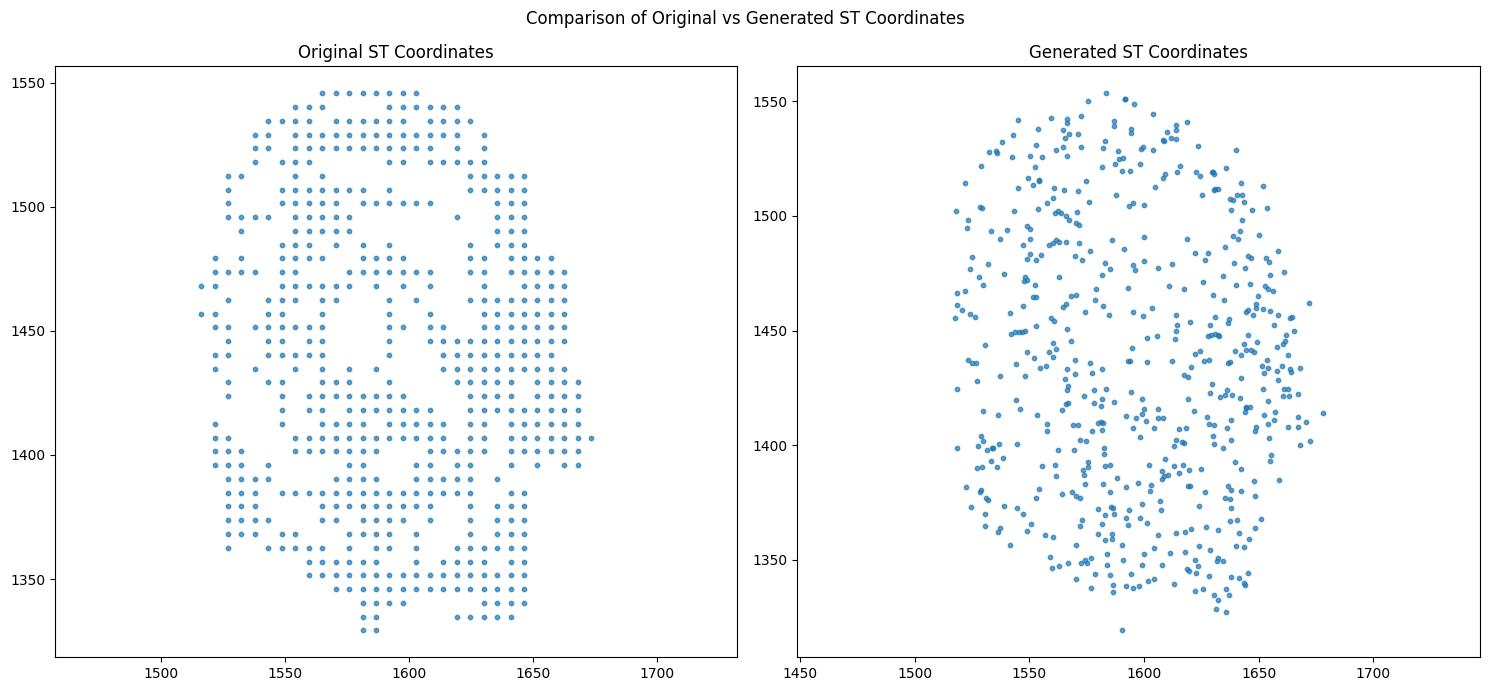

Sampling SC coordinates in batches...


Sampling batch 159/159: 100%|██████████| 800/800 [00:00<00:00, 817.01it/s]


Sampling complete!


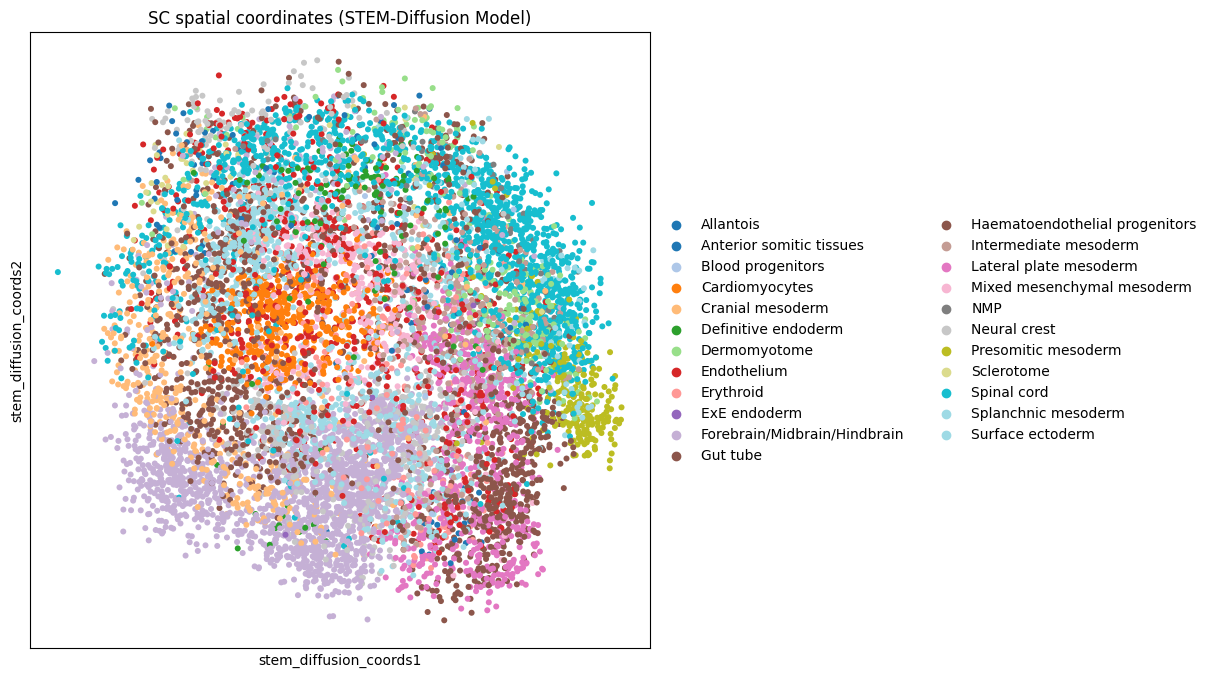

In [13]:
# Initialize the model
stem_diffusion = STEMDiffusion(
    st_gene_expr=X_st,
    st_coords=Y_st,
    D_st=D_st,  # Distance matrix for ST data
    sc_gene_expr=X_sc,
    D_induced=D_induced,  # Induced distance matrix from GW-OT
    outf='./stem_diffusion_output',
    device='cuda',
    n_genes=X_st.shape[1],
    n_embedding=[512, 256, 128],
    hidden_dim=256,
    dp=0.1,
    n_timesteps=800,
    beta_start=1e-4,
    beta_end=0.02,
    sigma=3.0,
    alpha=0.8,
    mmdbatch=1000,
    batch_size=256  # Adjust based on memory
)

# Train first encoder component (STEM-inspired) to align ST and SC
stem_diffusion.train_encoder(
    n_epochs=1000,
    ratio_start=0,
    ratio_end=1.0  # Gradually increase circle loss weight
)

# Train diffusion model using trained encoder
stem_diffusion.train_diffusion(
    n_epochs=2000,
    lambda_struct=10.0  # Weight for KL divergence structure loss
)

# Or use the combined training method
# stem_diffusion.train(encoder_epochs=1000, diffusion_epochs=2000)

# Generate ST coordinates to evaluate model (using batched approach to save memory)
st_gen_coords = stem_diffusion.generate_st_coordinates_batched(batch_size=64)

# Visualize and compare with original
import matplotlib.pyplot as plt

def plot_comparison(original_coords, generated_coords, title="Comparison of Original vs Generated ST Coordinates"):
    plt.figure(figsize=(15, 7))
    
    # Plot original coordinates
    plt.subplot(1, 2, 1)
    plt.scatter(original_coords[:, 0], original_coords[:, 1], alpha=0.7, s=10)
    plt.title("Original ST Coordinates")
    plt.axis('equal')
    
    # Plot generated coordinates
    plt.subplot(1, 2, 2)
    plt.scatter(generated_coords[:, 0], generated_coords[:, 1], alpha=0.7, s=10)
    plt.title("Generated ST Coordinates")
    plt.axis('equal')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Convert to numpy if needed
if isinstance(Y_st, torch.Tensor):
    Y_st_np = Y_st.cpu().numpy()
else:
    Y_st_np = Y_st

if isinstance(st_gen_coords, torch.Tensor):
    st_gen_np = st_gen_coords.cpu().numpy()
else:
    st_gen_np = st_gen_coords

# Plot ST comparison
plot_comparison(Y_st_np, st_gen_np)

# Once ST results look good, generate SC coordinates (also batched)
sc_coords = stem_diffusion.sample_sc_coordinates_batched(
    batch_size=64,
    timesteps=800,
    use_structure_guidance=True  # Use D_induced to guide generation
)

# Convert PyTorch tensor to NumPy array before assigning
if isinstance(sc_coords, torch.Tensor):
    sc_coords_np = sc_coords.cpu().numpy()
else:
    sc_coords_np = sc_coords

# Now assign the NumPy array to the obsm attribute
adata.obsm['stem_diffusion_coords'] = sc_coords_np

fig, ax = plt.subplots(figsize=(8, 8))  # your preferred size


# Visualization should now work
import scanpy as sc
sc.pl.embedding(adata, basis='stem_diffusion_coords', color='celltype_mapped_refined',
                size=75, title='SC spatial coordinates (STEM-Diffusion Model)',
                palette='tab20', legend_loc='right margin', legend_fontsize=10, ax=ax)

In [ ]:
sc_coords

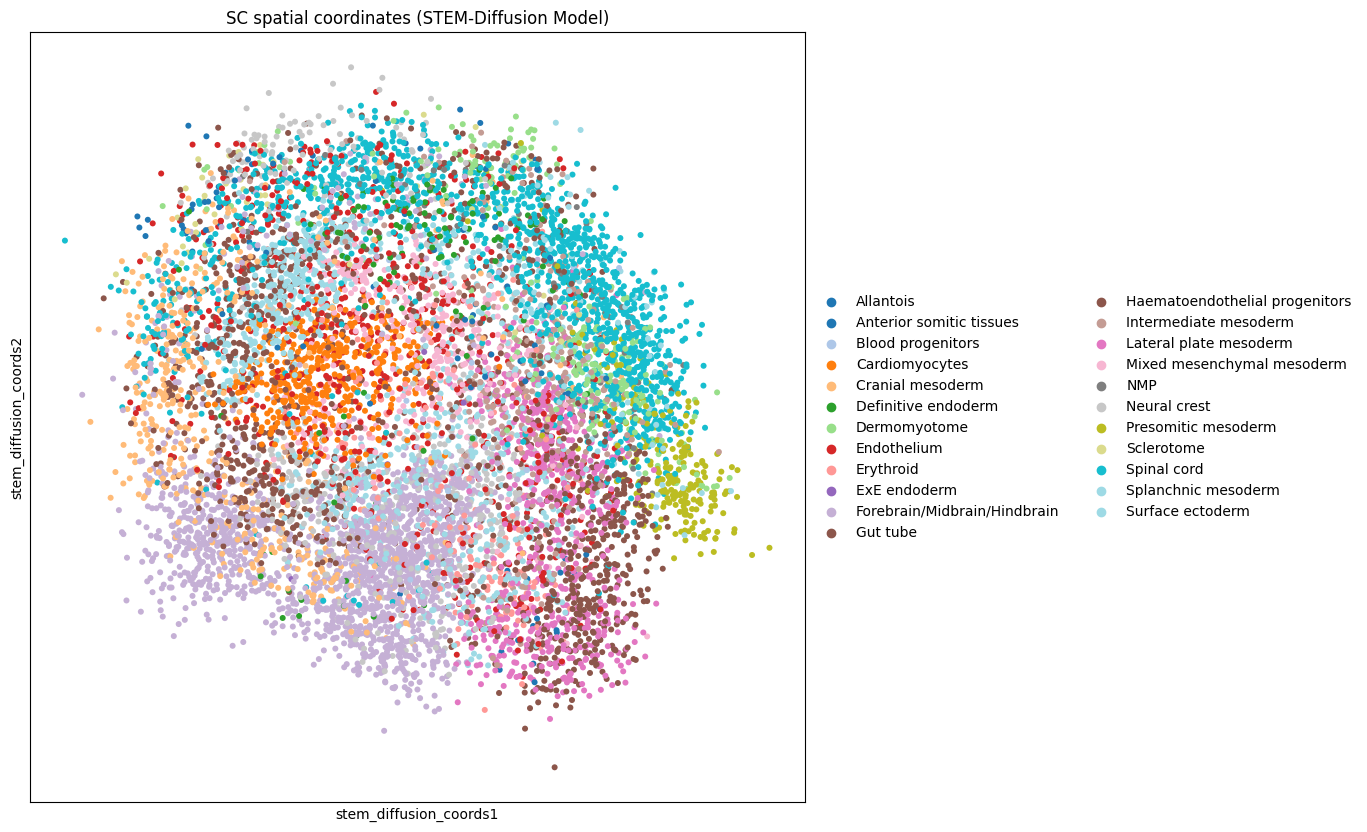

In [39]:
# Convert PyTorch tensor to NumPy array before assigning
if isinstance(sc_coords, torch.Tensor):
    sc_coords_np = sc_coords.cpu().numpy()
else:
    sc_coords_np = sc_coords

# Now assign the NumPy array to the obsm attribute
adata.obsm['stem_diffusion_coords'] = sc_coords_np

fig, ax = plt.subplots(figsize=(10, 10))  # your preferred size


# Visualization should now work
import scanpy as sc
sc.pl.embedding(adata, basis='stem_diffusion_coords', color='celltype_mapped_refined',
                size=75, title='SC spatial coordinates (STEM-Diffusion Model)',
                palette='tab20', legend_loc='right margin', legend_fontsize=10, ax=ax)

In [43]:
sc_coords

tensor([[1620.6367, 1365.6041],
        [1614.5471, 1368.7927],
        [1621.5449, 1320.8380],
        ...,
        [1557.2179, 1530.5959],
        [1548.4325, 1517.5278],
        [1542.1293, 1518.4614]])

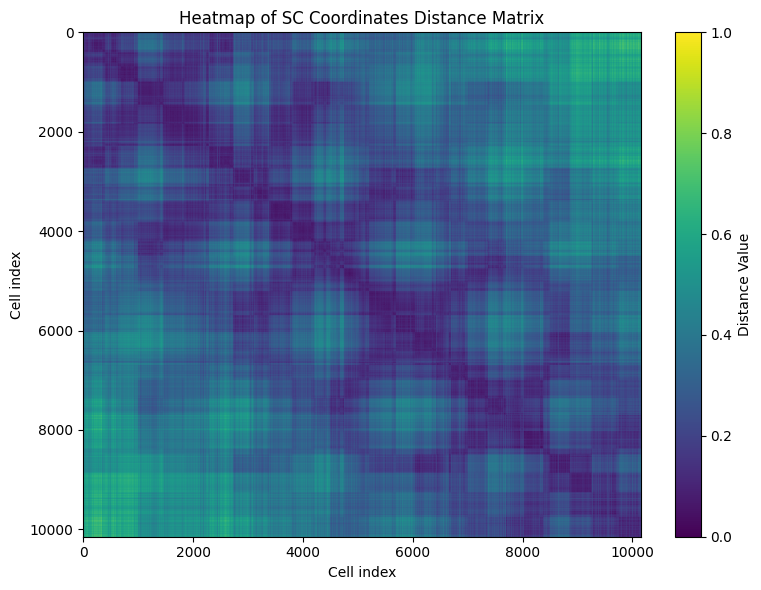

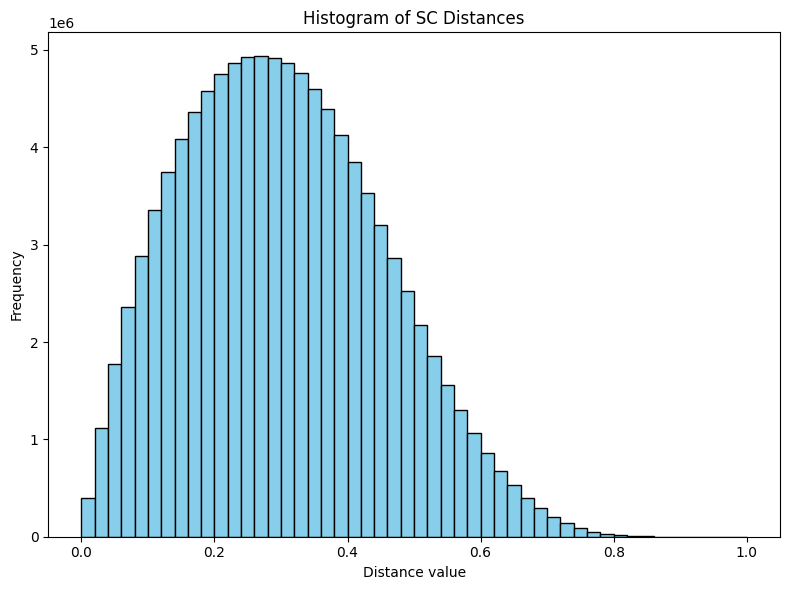

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Assuming sc_coords is your tensor of SC coordinates
# Convert to numpy array if it's a torch tensor
if isinstance(sc_coords, torch.Tensor):
    sc_coords_np = sc_coords.cpu().detach().numpy()
else:
    sc_coords_np = sc_coords

# Calculate Euclidean distance matrix
# Option 1: Using torch directly
with torch.no_grad():
    if isinstance(sc_coords, torch.Tensor):
        sc_dist_matrix = torch.cdist(sc_coords, sc_coords, p=2)
        sc_dist_matrix_np = sc_dist_matrix.cpu().numpy()
    else:
        # Option 2: Using scipy (more efficient for large matrices)
        pairwise_distances = pdist(sc_coords_np, metric='euclidean')
        sc_dist_matrix_np = squareform(pairwise_distances)

# Normalize the distance matrix
min_val = sc_dist_matrix_np.min()
max_val = sc_dist_matrix_np.max()
# Option 1: Min-max normalization
normalized_matrix = (sc_dist_matrix_np - min_val) / (max_val - min_val)
# Option 2: Max normalization
# normalized_matrix = sc_dist_matrix_np / max_val

# Plot a heatmap of the distance matrix
plt.figure(figsize=(8, 6))
plt.imshow(normalized_matrix, cmap='viridis', aspect='auto')
plt.title("Heatmap of SC Coordinates Distance Matrix")
plt.colorbar(label='Distance Value')
plt.xlabel("Cell index")
plt.ylabel("Cell index")
plt.tight_layout()
plt.show()

# Plot a histogram of the distance values
plt.figure(figsize=(8, 6))
plt.hist(normalized_matrix.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of SC Distances")
plt.xlabel("Distance value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# You can also visualize a subset for better clarity
# For example, first 500x500 cells if the matrix is too large
subset_size = min(500, normalized_matrix.shape[0])
plt.figure(figsize=(10, 8))
plt.imshow(normalized_matrix[:subset_size, :subset_size], cmap='viridis', aspect='auto')
plt.title(f"Heatmap of SC Distance Matrix (First {subset_size}x{subset_size} cells)")
plt.colorbar(label='Distance Value')
plt.xlabel("Cell index")
plt.ylabel("Cell index")
plt.tight_layout()
plt.show()

# Compare with D_induced (if available)
if 'D_induced' in locals() or 'D_induced' in globals():
    if isinstance(D_induced, torch.Tensor):
        D_induced_np = D_induced.cpu().detach().numpy()
    else:
        D_induced_np = D_induced
    
    D_induced_np = D_induced_np / D_induced_np.max()  # Normalize
    
    # Plot correlation between distance matrices if sizes match
    if D_induced_np.shape == normalized_matrix.shape:
        plt.figure(figsize=(8, 6))
        plt.scatter(
            D_induced_np.flatten(), 
            normalized_matrix.flatten(), 
            alpha=0.1, s=1
        )
        plt.title("Correlation: D_induced vs SC Coordinates Distance")
        plt.xlabel("D_induced distance")
        plt.ylabel("SC coordinates distance")
        plt.tight_layout()
        plt.show()

In [6]:
Y_st

array([[1581.24273186, 1329.31386432],
       [1586.66202567, 1329.31386432],
       [1581.24273186, 1334.86391917],
       ...,
       [1592.08131947, 1545.76600377],
       [1597.50061327, 1545.76600377],
       [1602.91990708, 1545.76600377]])

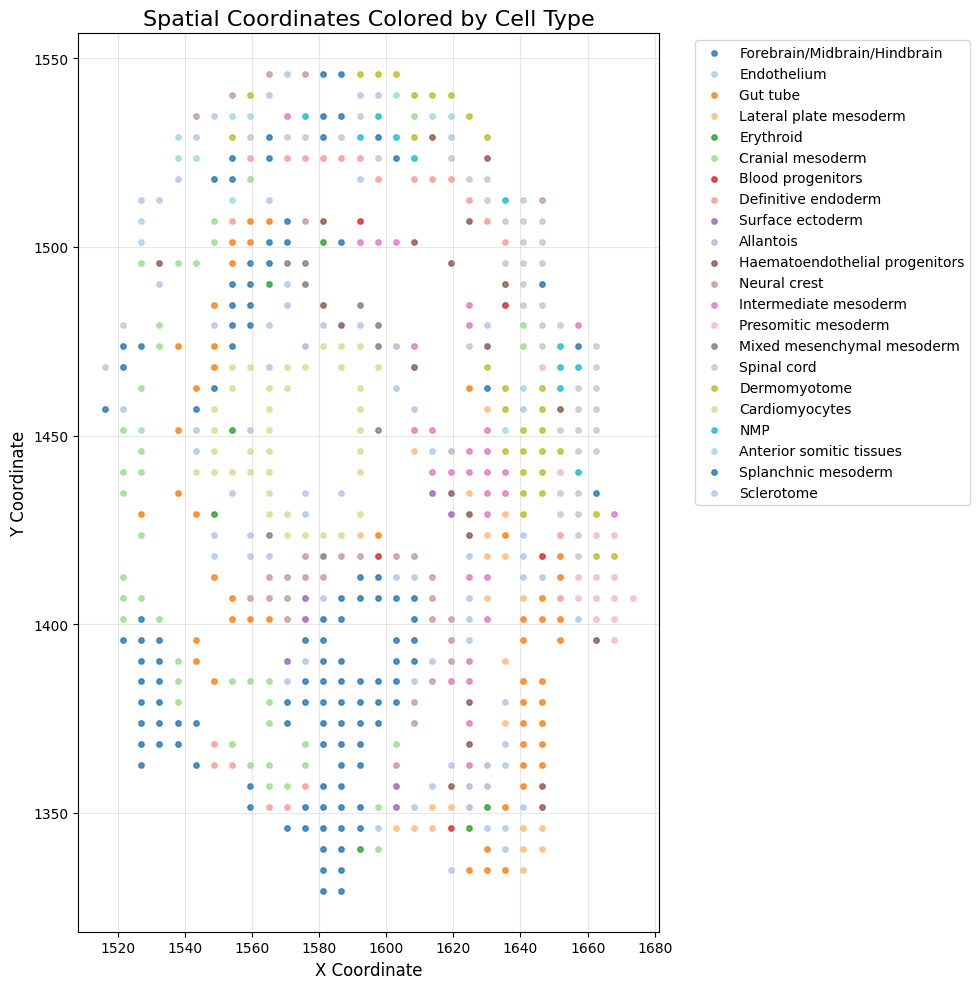

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import seaborn as sns
from matplotlib.colors import ListedColormap

# First, let's create an AnnData object to use with scanpy functions
# We'll use the spatial coordinates and cell type information

# Create DataFrame with spatial coordinates
coord_df = pd.DataFrame({
    'coord_x': spcoor['coord_x'],
    'coord_y': spcoor['coord_y']
})

# Get cell type information from stgtcelltype
# This is a binary matrix with spots as rows and cell types as columns
cell_type_columns = stgtcelltype.columns

# For each spot, find the dominant cell type (if any)
# We'll create a new column in our DataFrame for this
dominant_celltypes = []
for i in range(stgtcelltype.shape[0]):
    # Get the cell types present in this spot
    cell_types_present = [col for col, val in zip(cell_type_columns, stgtcelltype.iloc[i]) if val > 0]
    
    # If multiple cell types, take the first one (or modify to use the most abundant)
    dominant_celltype = cell_types_present[0] if cell_types_present else 'Unknown'
    dominant_celltypes.append(dominant_celltype)

# Add the dominant cell type to our DataFrame
coord_df['celltype'] = dominant_celltypes

# Create an AnnData object
adata = anndata.AnnData(X=np.zeros((len(coord_df), 1)))  # Empty expression matrix
adata.obs_names = [f"spot_{i}" for i in range(len(coord_df))]
adata.obs['celltype'] = coord_df['celltype']

# Add the spatial coordinates to the obsm attribute
adata.obsm['spatial'] = coord_df[['coord_x', 'coord_y']].values

# Method 2: Direct scatter plot with legend (alternative approach)
plt.figure(figsize=(10, 10))

# Get unique cell types for coloring
unique_celltypes = coord_df['celltype'].unique()

# Create a custom colormap
num_colors = len(unique_celltypes)
palette = sns.color_palette('tab20', n_colors=num_colors)
celltype_to_color = {celltype: palette[i] for i, celltype in enumerate(unique_celltypes)}

# Plot each cell type with a different color
for celltype in unique_celltypes:
    subset = coord_df[coord_df['celltype'] == celltype]
    plt.scatter(subset['coord_x'], subset['coord_y'], 
                color=celltype_to_color[celltype], 
                label=celltype, 
                alpha=0.8, 
                s=15)

plt.title('Spatial Coordinates Colored by Cell Type', fontsize=16)
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()



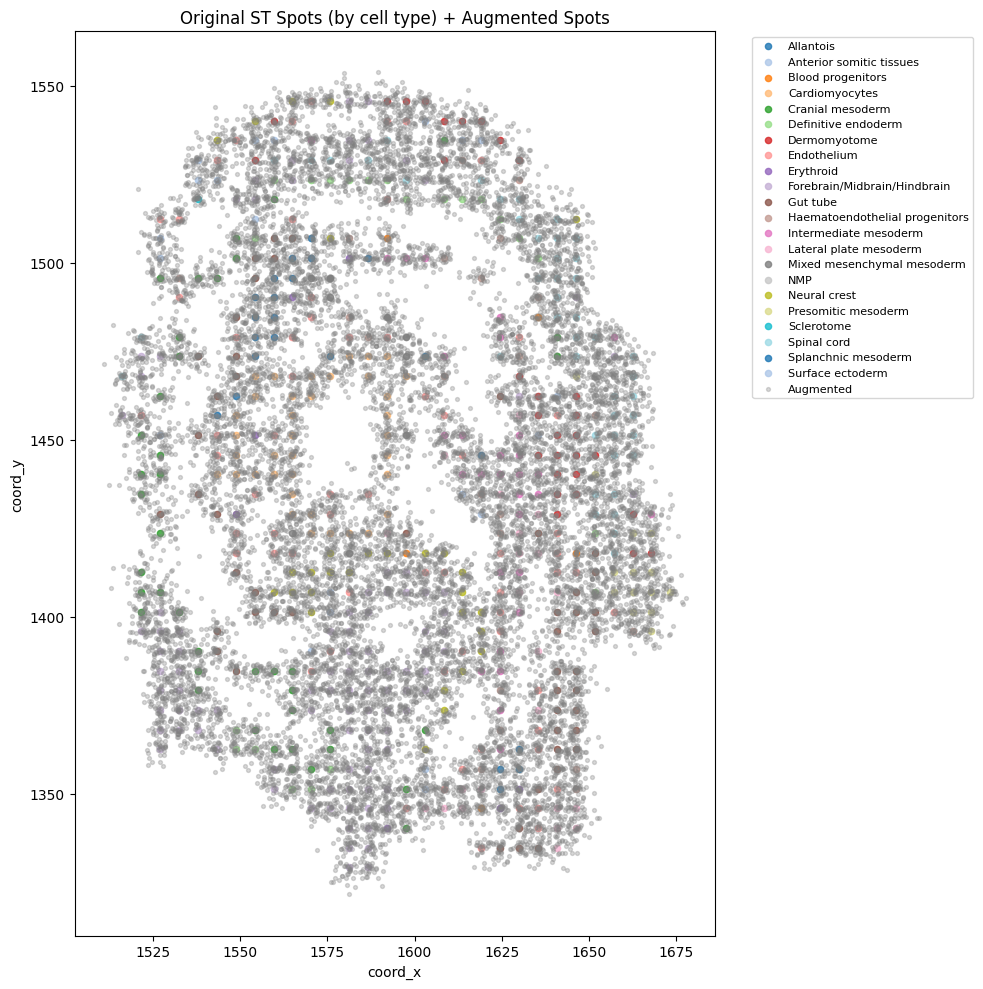

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1) Extract your existing arrays ---
# coords: N×2 array of your ST spot x,y
coords = spcoor[['coord_x','coord_y']].values

# dominant cell type per spot
dominant = stgtcelltype.apply(
    lambda row: row[row>0].index[0] if (row>0).any() else 'Unknown',
    axis=1
).values

# --- 2) Augmentation: just jitter the coordinates ---
def augment_coords(coords, n_aug_per_point=5, coord_jitter=(0.1,0.5)):
    aug = []
    for xy in coords:
        for _ in range(n_aug_per_point):
            # pick a random std between min and max
            σ = np.random.uniform(coord_jitter[0], coord_jitter[1])
            aug.append(xy + np.random.randn(2) * σ)

    return np.vstack(aug)

coords_aug = augment_coords(coords,
                            n_aug_per_point=30,
                            coord_jitter=(0.5,4))

# --- 3) Plot everything ---
plt.figure(figsize=(10,10))

# original spots, colored by cell type
unique_ct = np.unique(dominant)
palette   = sns.color_palette('tab20', n_colors=len(unique_ct))
ct_to_color = {ct: palette[i] for i, ct in enumerate(unique_ct)}

for ct in unique_ct:
    mask = (dominant == ct)
    plt.scatter(coords[mask,0], coords[mask,1],
                color=ct_to_color[ct],
                label=ct,
                s=20, alpha=0.8)

# augmented spots in gray
plt.scatter(coords_aug[:,0], coords_aug[:,1],
            color='gray', label='Augmented',
            s=8, alpha=0.3)

plt.title('Original ST Spots (by cell type) + Augmented Spots')
plt.xlabel('coord_x')
plt.ylabel('coord_y')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


In [14]:
coords_aug.shape

(17430, 2)

In [25]:
np.random.rand(2)

array([0.86464038, 0.22914803])

In [15]:
X_st.shape

torch.Size([581, 351])

In [17]:
coords_aug

array([[1576.66336571, 1325.17517905],
       [1580.31319121, 1330.10346609],
       [1579.95921538, 1329.57452692],
       ...,
       [1603.08068682, 1546.77945115],
       [1604.25502224, 1547.79851331],
       [1603.16191036, 1546.4675108 ]])

In [43]:
drop_gene_p = 0.2
for x , xy in zip(X_st, coords):
    # print(x)
    mask = (np.random.rand(*x.shape) > drop_gene_p).astype(float)   

In [42]:
mask

array([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [55]:
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from scipy.special import expit

# 1) Load your ST counts and coords
st_raw = pd.read_csv('data/mousedata_2020/E1z2/simu_st_counts.csv', index_col=0).T
coords = pd.read_csv('data/mousedata_2020/E1z2/simu_st_metadata.csv', index_col=0)[['coord_x','coord_y']].values

# 2) Optionally normalize & log‐transform
adata = sc.AnnData(st_raw)

In [56]:
# 2) Highly‐variable gene selection with cell_ranger flavor
adata_st = sc.AnnData(st_raw)
sc.pp.highly_variable_genes(adata_st, n_top_genes=500, flavor='cell_ranger')
hvg_mask = adata_st.var['highly_variable'].values
X_all = (adata.X if hasattr(adata, 'X') else st_raw.values).astype(np.float32)[:, hvg_mask]
# X_counts = st_raw.values[:, hvg_mask].astype(np.float32)  # N_spots × 500 HVGs

In [57]:
X_all

array([[0., 1., 0., ..., 3., 4., 1.],
       [0., 1., 2., ..., 0., 6., 2.],
       [5., 5., 2., ..., 8., 7., 3.],
       ...,
       [2., 1., 0., ..., 2., 5., 3.],
       [3., 0., 1., ..., 5., 6., 2.],
       [0., 1., 3., ..., 2., 5., 4.]], dtype=float32)

In [51]:
X_counts

array([[0., 1., 0., ..., 3., 4., 1.],
       [0., 1., 2., ..., 0., 6., 2.],
       [5., 5., 2., ..., 8., 7., 3.],
       ...,
       [2., 1., 0., ..., 2., 5., 3.],
       [3., 0., 1., ..., 5., 6., 2.],
       [0., 1., 3., ..., 2., 5., 4.]], dtype=float32)

In [52]:
# 3) PyTorch dataset & loader
dataset = TensorDataset(torch.from_numpy(X_counts))
loader  = DataLoader(dataset, batch_size=32, shuffle=True)

In [54]:
loader

In [87]:
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from scipy.special import expit
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from sklearn.neighbors import NearestNeighbors


# 1) Load your ST counts and coords
st_raw = pd.read_csv('data/mousedata_2020/E1z2/simu_st_counts.csv', index_col=0).T
coords = pd.read_csv('data/mousedata_2020/E1z2/simu_st_metadata.csv', index_col=0)[['coord_x','coord_y']].values

# 2) Optionally normalize & log‐transform
adata = sc.AnnData(st_raw)

# 2) Highly‐variable gene selection with cell_ranger flavor
adata_st = sc.AnnData(st_raw)
X_umi = (adata.X if hasattr(adata, 'X') else st_raw.values).astype(np.float32).astype(np.float32)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
X_log = adata.X.astype(np.float32)
# sc.pp.highly_variable_genes(adata_st, n_top_genes=500, flavor='cell_ranger')
# hvg_mask = adata_st.var['highly_variable'].values
# X_all = (adata.X if hasattr(adata, 'X') else st_raw.values).astype(np.float32)[:, hvg_mask]


class NB_VAE(nn.Module):
    def __init__(self, n_input, n_latent = 10, hidden= 128, phi = 1.0):
        super().__init__()
        self.n_input = n_input
        # self.phi = phi
        self.log_phi = nn.Parameter(torch.zeros(n_input))
        #encoder 
        self.enc1 = nn.Linear(n_input, hidden)
        self.enc2 = nn.Linear(hidden, n_latent*2)
        #decoder for rate r
        self.dec_r1 = nn.Linear(n_latent, hidden)
        self.dec_r2 = nn.Linear(hidden, n_input)
        #decoder for logit p
        self.dec_p1 = nn.Linear(n_latent, hidden)
        self.dec_p2 = nn.Linear(hidden, n_input)

    def encode(self, x):
        h = F.dropout(x, p=0.1, training=self.training)
        h = torch.tanh(self.enc1(h))
        h = self.enc2(h)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar
    
    def reparam(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode_r(self, z):
        h = torch.tanh(self.dec_r1(z))
        return F.softplus(self.dec_r2(h)) + 1e-6
    
    def decode_p(self, z):
        h = torch.tanh(self.dec_p1(z))
        return self.dec_p2(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        r = self.decode_r(z)
        p_logit = self.decode_p(z)
        phi = torch.exp(self.log_phi)
        return r, p_logit, mu, logvar, phi
    
#nb negative log likelihood + KL
def nb_loss(x, r, p_logit, phi):
    #x, r: [B, G], p_logit: logits
    p = torch.sigmoid(p_logit)
    phi_t = torch.tensor(phi, dtype=x.dtype, device=x.device)

    t1 = torch.lgamma(phi_t + x) - torch.lgamma(phi_t) - torch.lgamma(x+1)
    t2 = phi_t * (torch.log(phi_t) - torch.log(phi_t + r))
    t3 = x * (torch.log(r) - torch.log(phi_t +r))
    ll = t1 + t2 + t3
    return -ll.sum(dim=1).mean() #negative log-like over genes then mean over batch

def kl_loss(mu, logvar):
    return 0.5 * torch.sum(-logvar + logvar.exp() + mu.pow(2)-1, dim=1).mean()


#train
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = TensorDataset(torch.from_numpy(X_umi))
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = NB_VAE(n_input=X_umi.shape[1], n_latent=10).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 400

for ep in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for (xb, ) in loader:
        xb = xb.to(device)
        r, p_logit, mu, logvar, phi = model(xb)
        loss = nb_loss(xb, r, p_logit, phi) + kl_loss(mu, logvar) * min(1., ep/200)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)
    print(f'epoch {ep}/{n_epochs} avg_loss={(total_loss/len(dataset)):.4f}')

#generate 30x synthetic spots + jittered coords
model.eval()
with torch.no_grad():
    X_tensor = torch.from_numpy(X_umi).to(device)
    r_all, p_logit_all, mu_all, logvar_all, _ = model(X_tensor)
    r_all = r_all.cpu().numpy()
    p_all = expit(p_logit_all.cpu().numpy())

    z_orig = mu_all.cpu().numpy() #[n spots * latent dim]

X_synth, coords_synth = [], []
n_aug = 50
sigma = 0.05

# for i in range(X_all.shape[0]):
#     for _ in range(n_aug):
#         r_i = r_all[i:i+1]
#         p_i = p_all[i:i+1]
#         #nb sample
#         r_param = r_i * (1 - p_i)/ (p_i + 1e-8)
#         X_new = np.random.negative_binomial(r_param, p_i).astype(np.float32).squeeze()
#         X_synth.append(X_new)
#         #jitter coords
#         coords_synth.append(coords[i] + np.random.randn(2) * sigma)

# for i in range(X_all.shape[0]):
#     for _ in range(n_aug):
#         r_i = r_all[i]
#         p_i = p_all[i]
#         mu_i = r_i * (1-p_i)/p_i
#         #draw lambda ~ Gamma(shape=r_i, scale = mu_i/r_i)
#         lam = np.random.gamma(shape=r_i, scale=(mu_i/r_i))
#         #then draw counts ~ Possion(lam)
#         X_new = np.random.poisson(lam).astype(np.float32).squeeze()
#         X_synth.append(X_new)
#         coords_synth.append(coords[i] + np.random.randn(2)*sigma)

orig_totals = X_umi.sum(axis=1)  # shape (N_real,)
  
# inside your augmentation loop, replacing the nb sample & jitter step:
for i in range(X_umi.shape[0]):
    # 1) draw an NB sample as before
    r_i = r_all[i:i+1]
    p_i = p_all[i:i+1]
    r_param = r_i * (1 - p_i) / (p_i + 1e-8)
    for _ in range(n_aug):
        X_new = np.random.negative_binomial(r_param, p_i).astype(np.float32).squeeze()
        X_synth.append(X_new)

        # 4) jitter coords exactly as before
        # coords_synth.append(coords[i] + np.random.randn(2) * sigma)

X_synth = np.stack(X_synth)
# coords_synth = np.stack(coords_synth)

#re encode synth into latent and interpolate coords
model.eval()
with torch.no_grad():
    Zs_t = torch.from_numpy(X_synth).to(device)
    mu_syn, _ = model.encode(Zs_t)
    z_syn = mu_syn.cpu().numpy()

# #build knn on the og z-space
# nbrs = NearestNeighbors(n_neighbors=5).fit(z_orig)
# dists, idxs = nbrs.kneighbors(z_syn)
# w = np.exp(-dists)
# w/= w.sum(axis=1, keepdims=True)

# #weighted avg of the 5 real coords
# coords_synth = (w[:, :, None] * coords[idxs]).sum(axis=1)


from scipy.spatial import ConvexHull

# 0) original real data
real_coords = coords.copy()       # (N_real,2)
real_z      = z_orig.copy()       # (N_real,latent_dim)
real_X      = X_umi.copy()        # (N_real,genes)

# 1) synthetic counts (your NB‐VAE + jitter) → X_synth, z_syn already exist
#    shape X_synth=(N_synth,genes), z_syn=(N_synth,latent_dim)

# 2) boost boundary: make extra coords and dummy z’s (we’ll re‐encode them, or you can skip)
hull = ConvexHull(real_coords)
boundary_idxs = hull.vertices
center = real_coords.mean(0)

extra_coords = []
extra_X      = []
for i in boundary_idxs:
    base = real_coords[i]
    out  = base - center
    out /= np.linalg.norm(out)
    for _ in range(20):
        jittered = base + 0.01 * out * np.random.rand()
        extra_coords.append(jittered)
        # if you want to give them “counts” you could re‐sample from the NB‐VAE,
        # or you can just copy the original X_umi[i]
        extra_X.append(real_X[i])

extra_coords = np.array(extra_coords)      # (N_extra,2)
extra_X = np.array(extra_X)           # (N_extra,genes)

# 3) join all synth pools
all_X   = np.vstack([X_synth, extra_X])     # (N_synth+N_extra,genes)
all_z   = np.vstack([z_syn, model.encode(torch.from_numpy(extra_X).to(device))[0].detach().cpu().numpy()]) 
# or simply re‐encode extra_coords if you prefer
all_coords = np.vstack([extra_coords])           # we'll compute final below

# 4) Dirichlet‐weighted KNN interpolation _once_ on the big pool
nbrs = NearestNeighbors(n_neighbors=5).fit(real_z)  # only real z’s as reference
d, idx = nbrs.kneighbors(all_z)                    # shape (N_big,5)

alpha = 0.1
w = np.random.dirichlet([alpha]*5, size=len(all_z)) # (N_big,5)

coords_synth = (real_coords[idx] * w[:,:,None]).sum(1)  # (N_big,2)

# 5) Radial expansion of both real and synthetic
scale = 1.05
c0 = real_coords.mean(0)

real_coords   = (real_coords   - c0)*scale + c0
coords_synth  = (coords_synth  - c0)*scale + c0

# 6) final concat
X_aug = np.vstack([real_X,   all_X])         # (N_real + N_big, genes)
C_aug = np.vstack([real_coords, coords_synth])  # (N_real + N_big, 2)


# from sklearn.neighbors import NearestNeighbors
# import torch
# import numpy as np

# # 1) Start with only the real pool
# z_pool     = z_orig.copy()     # real latents, shape (N_real, D)
# coord_pool = coords.copy()     # real coords,   shape (N_real, 2)
# k = 5

# # initial KNN on the real data
# nbrs = NearestNeighbors(n_neighbors=k).fit(z_pool)

# coords_synth = []

# model.eval()
# with torch.no_grad():
#     # 2) Iterate over each synthetic count vector
#     for x_new in X_synth:                    # x_new shape (G,)
#         # encode into latent
#         xb = torch.from_numpy(x_new[None]).to(device).float()
#         mu_new, _ = model.encode(xb)
#         z_new = mu_new.cpu().numpy()         # shape (1, D)

#         # find k‐NN among *all* placed so far
#         dists, idxs = nbrs.kneighbors(z_new)  # both shape (1, k)
#         dists, idxs = dists[0], idxs[0]

#         # weight by e^(–dist)
#         w = np.exp(-dists)
#         w /= w.sum()

#         # weighted average of their coords
#         coord_new = (coord_pool[idxs] * w[:, None]).sum(axis=0)
#         coords_synth.append(coord_new)

#         # 3) add the new point to the pool
#         z_pool     = np.vstack([z_pool,     z_new])
#         coord_pool = np.vstack([coord_pool, coord_new[None]])

#         # 4) rebuild KNN index
#         nbrs = NearestNeighbors(n_neighbors=k).fit(z_pool)

# coords_synth = np.vstack(coords_synth)  # final (N_synth, 2)


# 4) CONCAT  ---------------------------------------------------------------
# X_aug = np.vstack([X_umi,  X_synth])
# C_aug = np.vstack([coords, coords_synth])

print("Original:", X_umi.shape[0], "Augmented total:", X_aug.shape[0])


/tmp/ipykernel_4167689/2934300380.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi_t = torch.tensor(phi, dtype=x.dtype, device=x.device)


epoch 1/400 avg_loss=950.5020
epoch 2/400 avg_loss=760.4201
epoch 3/400 avg_loss=728.7645
epoch 4/400 avg_loss=722.2977
epoch 5/400 avg_loss=719.8089
epoch 6/400 avg_loss=718.1887


epoch 7/400 avg_loss=717.2738
epoch 8/400 avg_loss=716.2991
epoch 9/400 avg_loss=715.4514
epoch 10/400 avg_loss=714.1795
epoch 11/400 avg_loss=712.2491
epoch 12/400 avg_loss=710.3818
epoch 13/400 avg_loss=707.9610
epoch 14/400 avg_loss=705.5195
epoch 15/400 avg_loss=702.9179
epoch 16/400 avg_loss=700.0801
epoch 17/400 avg_loss=697.7603
epoch 18/400 avg_loss=695.7036
epoch 19/400 avg_loss=693.6571
epoch 20/400 avg_loss=692.5083
epoch 21/400 avg_loss=690.5380
epoch 22/400 avg_loss=688.5811
epoch 23/400 avg_loss=687.5206
epoch 24/400 avg_loss=686.2089
epoch 25/400 avg_loss=684.5102
epoch 26/400 avg_loss=682.4824
epoch 27/400 avg_loss=681.4202
epoch 28/400 avg_loss=679.9130
epoch 29/400 avg_loss=678.9873
epoch 30/400 avg_loss=678.2756
epoch 31/400 avg_loss=677.0477
epoch 32/400 avg_loss=675.8124
epoch 33/400 avg_loss=675.5850
epoch 34/400 avg_loss=675.0033
epoch 35/400 avg_loss=673.9755
epoch 36/400 avg_loss=673.0047
epoch 37/400 avg_loss=673.9686
epoch 38/400 avg_loss=672.5385
epoch 39/40

In [84]:
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from scipy.special import expit
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from sklearn.neighbors import NearestNeighbors


# 1) Load your ST counts and coords
st_raw = pd.read_csv('data/mousedata_2020/E1z2/simu_st_counts.csv', index_col=0).T
coords = pd.read_csv('data/mousedata_2020/E1z2/simu_st_metadata.csv', index_col=0)[['coord_x','coord_y']].values

# 2) Optionally normalize & log‐transform
adata = sc.AnnData(st_raw)

# 2) Highly‐variable gene selection with cell_ranger flavor
adata_st = sc.AnnData(st_raw)
X_umi = (adata.X if hasattr(adata, 'X') else st_raw.values).astype(np.float32).astype(np.float32)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
X_log = adata.X.astype(np.float32)
# sc.pp.highly_variable_genes(adata_st, n_top_genes=500, flavor='cell_ranger')
# hvg_mask = adata_st.var['highly_variable'].values
# X_all = (adata.X if hasattr(adata, 'X') else st_raw.values).astype(np.float32)[:, hvg_mask]


class NB_VAE(nn.Module):
    def __init__(self, n_input, n_latent = 10, hidden= 128, phi = 1.0):
        super().__init__()
        self.n_input = n_input
        # self.phi = phi
        self.log_phi = nn.Parameter(torch.zeros(n_input))
        #encoder 
        self.enc1 = nn.Linear(n_input, hidden)
        self.enc2 = nn.Linear(hidden, n_latent*2)
        #decoder for rate r
        self.dec_r1 = nn.Linear(n_latent, hidden)
        self.dec_r2 = nn.Linear(hidden, n_input)
        #decoder for logit p
        self.dec_p1 = nn.Linear(n_latent, hidden)
        self.dec_p2 = nn.Linear(hidden, n_input)

    def encode(self, x):
        h = F.dropout(x, p=0.1, training=self.training)
        h = torch.tanh(self.enc1(h))
        h = self.enc2(h)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar
    
    def reparam(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode_r(self, z):
        h = torch.tanh(self.dec_r1(z))
        return F.softplus(self.dec_r2(h)) + 1e-6
    
    def decode_p(self, z):
        h = torch.tanh(self.dec_p1(z))
        return self.dec_p2(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        r = self.decode_r(z)
        p_logit = self.decode_p(z)
        phi = torch.exp(self.log_phi)
        return r, p_logit, mu, logvar, phi
    
#nb negative log likelihood + KL
def nb_loss(x, r, p_logit, phi):
    #x, r: [B, G], p_logit: logits
    p = torch.sigmoid(p_logit)
    phi_t = torch.tensor(phi, dtype=x.dtype, device=x.device)

    t1 = torch.lgamma(phi_t + x) - torch.lgamma(phi_t) - torch.lgamma(x+1)
    t2 = phi_t * (torch.log(phi_t) - torch.log(phi_t + r))
    t3 = x * (torch.log(r) - torch.log(phi_t +r))
    ll = t1 + t2 + t3
    return -ll.sum(dim=1).mean() #negative log-like over genes then mean over batch

def kl_loss(mu, logvar):
    return 0.5 * torch.sum(-logvar + logvar.exp() + mu.pow(2)-1, dim=1).mean()


#train
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = TensorDataset(torch.from_numpy(X_umi))
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = NB_VAE(n_input=X_umi.shape[1], n_latent=10).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 400

for ep in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for (xb, ) in loader:
        xb = xb.to(device)
        r, p_logit, mu, logvar, phi = model(xb)
        loss = nb_loss(xb, r, p_logit, phi) + kl_loss(mu, logvar) * min(1., ep/200)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)
    print(f'epoch {ep}/{n_epochs} avg_loss={(total_loss/len(dataset)):.4f}')

#generate 30x synthetic spots + jittered coords
model.eval()
with torch.no_grad():
    X_tensor = torch.from_numpy(X_umi).to(device)
    r_all, p_logit_all, mu_all, logvar_all, _ = model(X_tensor)
    r_all = r_all.cpu().numpy()
    p_all = expit(p_logit_all.cpu().numpy())

    z_orig = mu_all.cpu().numpy() #[n spots * latent dim]

X_synth, coords_synth = [], []
n_aug = 50
sigma = 0.05

orig_totals = X_umi.sum(axis=1)  # shape (N_real,)
  
# inside your augmentation loop, replacing the nb sample & jitter step:
for i in range(X_umi.shape[0]):
    # 1) draw an NB sample as before
    r_i = r_all[i:i+1]
    p_i = p_all[i:i+1]
    r_param = r_i * (1 - p_i) / (p_i + 1e-8)
    for _ in range(n_aug):
        X_new = np.random.negative_binomial(r_param, p_i).astype(np.float32).squeeze()
        X_synth.append(X_new)

        # 4) jitter coords exactly as before
        # coords_synth.append(coords[i] + np.random.randn(2) * sigma)

X_synth = np.stack(X_synth)
# coords_synth = np.stack(coords_synth)

#re encode synth into latent and interpolate coords
model.eval()
with torch.no_grad():
    Zs_t = torch.from_numpy(X_synth).to(device)
    mu_syn, _ = model.encode(Zs_t)
    z_syn = mu_syn.cpu().numpy()

# #build knn on the og z-space
# nbrs = NearestNeighbors(n_neighbors=5).fit(z_orig)
# dists, idxs = nbrs.kneighbors(z_syn)
# w = np.exp(-dists)
# w/= w.sum(axis=1, keepdims=True)

# #weighted avg of the 5 real coords
# coords_synth = (w[:, :, None] * coords[idxs]).sum(axis=1)
from sklearn.neighbors import NearestNeighbors, KernelDensity
from scipy.spatial import Delaunay
import scipy.stats as stats

# 0) original real data
real_coords = coords.copy()       # (N_real,2)
real_z      = z_orig.copy()       # (N_real,latent_dim)
real_X      = X_umi.copy()        # (N_real,genes)


kde = KernelDensity(bandwidth=5.0, kernel='gaussian')
kde.fit(real_coords)
log_density = kde.score_samples(real_coords)
density = np.exp(log_density)
density_normalized = density / np.max(density)

#create delaunay triangulation to identify structure
try:
    tri = Delaunay(real_coords)
    has_triangulation = True
except Exception:
    has_triangulation = False

#improved boundary detection using alpha squares
from scipy.spatial import ConvexHull

hull = ConvexHull(real_coords)
boundary_idxs = hull.vertices
center = real_coords.mean(0)

# Add points along edges of the hull, not just vertices
boundary_edges = []
for simplex in hull.simplices:
    for i in range(len(simplex)):
        edge = (simplex[i], simplex[(i + 1) % len(simplex)])
        boundary_edges.append(edge)


#generate additional boundary points with structure preservung jitter
extra_coords = []
extra_X = []

# Add points along boundary edges
for edge in boundary_edges:
    p1, p2 = real_coords[edge[0]], real_coords[edge[1]]
    # Skip edges that are too long (might cross empty regions)
    if np.linalg.norm(p1 - p2) > 10.0:  # Adjust threshold based on your data
        continue
        
    for t in np.linspace(0.2, 0.8, 5):  # Add points along edge
        # Interpolate between edge points
        point = p1 * t + p2 * (1-t)
        # Add small outward jitter
        vec_out = point - center
        vec_out = vec_out / (np.linalg.norm(vec_out) + 1e-10)
        jitter = vec_out * np.random.uniform(0, 2.0)  # Adjust scale as needed
        
        extra_coords.append(point + jitter)
        
        # Use the gene expression of the nearest original point
        nearest_idx = np.argmin(np.linalg.norm(real_coords - point, axis=1))
        extra_X.append(real_X[nearest_idx])

# Add points around boundary vertices with outward bias
for i in boundary_idxs:
    base = real_coords[i]
    out_vec = base - center
    out_vec = out_vec / (np.linalg.norm(out_vec) + 1e-10)
    
    # Generate more boundary points in lower density regions
    n_points = int(10 * (1 - density_normalized[i] + 0.1))
    
    for _ in range(n_points):
        # Outward bias plus tangential component to follow boundary
        jitter_scale = np.random.uniform(1.0, 3.0)  # Adjust as needed
        jitter = out_vec * jitter_scale + np.random.normal(0, 0.5, 2)
        jittered = base + jitter
        
        # Check if the jittered point is too far from any real point
        dists = np.linalg.norm(real_coords - jittered, axis=1)
        if np.min(dists) > 15.0:  # Adjust threshold as needed
            continue
            
        extra_coords.append(jittered)
        extra_X.append(real_X[i])

extra_coords = np.array(extra_coords)
extra_X = np.array(extra_X)

# 5) Structure-preserving sampling for internal points
all_X = np.vstack([X_synth, extra_X])
all_z = np.vstack([z_syn, model.encode(torch.from_numpy(extra_X).to(device))[0].detach().cpu().numpy()])

# 6) Improved coordinate interpolation with local structure preservation
nbrs = NearestNeighbors(n_neighbors=5).fit(real_z)
d, idx = nbrs.kneighbors(all_z)

# Distance decay weighting (closer points have more influence)
weights = np.exp(-d**2 / (2 * 5.0**2))  # Gaussian kernel
weights = weights / weights.sum(axis=1, keepdims=True)

# Check if points belong to the same structure component
coords_synth = np.zeros((len(all_z), 2))

for i in range(len(all_z)):
    neighbor_coords = real_coords[idx[i]]
    
    # If we have triangulation, check if neighbors are in same triangle
    if has_triangulation:
        # Find simplices containing neighbors and prioritize those connections
        # This is a simplified approximation
        pass
    
    # Apply weighted interpolation
    coords_synth[i] = np.sum(neighbor_coords * weights[i, :, np.newaxis], axis=0)
    
    # Add small noise to prevent perfect alignment
    noise = np.random.normal(0, 0.2, 2)
    coords_synth[i] += noise

# 7) Remove points that fall in whitespace (low density regions)
# This helps preserve the tissue structure's natural boundaries
synth_density = np.exp(kde.score_samples(coords_synth))
synth_density_norm = synth_density / np.max(density)
valid_mask = synth_density_norm > 0.05  # Adjust threshold based on your data

# Filter out points in low-density regions
coords_synth = coords_synth[valid_mask]
all_X = all_X[valid_mask]

# 8) Combine with original data
X_aug = np.vstack([real_X, all_X])
C_aug = np.vstack([real_coords, coords_synth])


print("Original:", X_umi.shape[0], "Augmented total:", X_aug.shape[0])

/tmp/ipykernel_4167689/3672351372.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi_t = torch.tensor(phi, dtype=x.dtype, device=x.device)


epoch 1/400 avg_loss=976.0553
epoch 2/400 avg_loss=765.7002
epoch 3/400 avg_loss=729.9969
epoch 4/400 avg_loss=722.5109
epoch 5/400 avg_loss=719.7888
epoch 6/400 avg_loss=718.3426
epoch 7/400 avg_loss=717.1784
epoch 8/400 avg_loss=716.2620
epoch 9/400 avg_loss=715.1759
epoch 10/400 avg_loss=714.2300
epoch 11/400 avg_loss=712.5006
epoch 12/400 avg_loss=710.0216
epoch 13/400 avg_loss=707.7521
epoch 14/400 avg_loss=703.8567
epoch 15/400 avg_loss=700.4341
epoch 16/400 avg_loss=699.3766
epoch 17/400 avg_loss=696.1166
epoch 18/400 avg_loss=693.7506
epoch 19/400 avg_loss=691.1979
epoch 20/400 avg_loss=689.3284
epoch 21/400 avg_loss=687.9644
epoch 22/400 avg_loss=686.0003
epoch 23/400 avg_loss=684.9230
epoch 24/400 avg_loss=682.9116
epoch 25/400 avg_loss=681.7871
epoch 26/400 avg_loss=680.2203
epoch 27/400 avg_loss=679.4555
epoch 28/400 avg_loss=677.8871
epoch 29/400 avg_loss=677.3118
epoch 30/400 avg_loss=676.2596
epoch 31/400 avg_loss=675.2334
epoch 32/400 avg_loss=674.4909
epoch 33/400 avg_

In [82]:

import numpy as np
import pandas as pd
import scanpy as sc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from scipy.special import expit
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from sklearn.neighbors import NearestNeighbors


# 1) Load your ST counts and coords
st_raw = pd.read_csv('data/mousedata_2020/E1z2/simu_st_counts.csv', index_col=0).T
coords = pd.read_csv('data/mousedata_2020/E1z2/simu_st_metadata.csv', index_col=0)[['coord_x','coord_y']].values

# 2) Optionally normalize & log‐transform
adata = sc.AnnData(st_raw)

# 2) Highly‐variable gene selection with cell_ranger flavor
adata_st = sc.AnnData(st_raw)
X_umi = (adata.X if hasattr(adata, 'X') else st_raw.values).astype(np.float32).astype(np.float32)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
X_log = adata.X.astype(np.float32)
# sc.pp.highly_variable_genes(adata_st, n_top_genes=500, flavor='cell_ranger')
# hvg_mask = adata_st.var['highly_variable'].values
# X_all = (adata.X if hasattr(adata, 'X') else st_raw.values).astype(np.float32)[:, hvg_mask]


class NB_VAE(nn.Module):
    def __init__(self, n_input, n_latent = 10, hidden= 128, phi = 1.0):
        super().__init__()
        self.n_input = n_input
        # self.phi = phi
        self.log_phi = nn.Parameter(torch.zeros(n_input))
        #encoder 
        self.enc1 = nn.Linear(n_input, hidden)
        self.enc2 = nn.Linear(hidden, n_latent*2)
        #decoder for rate r
        self.dec_r1 = nn.Linear(n_latent, hidden)
        self.dec_r2 = nn.Linear(hidden, n_input)
        #decoder for logit p
        self.dec_p1 = nn.Linear(n_latent, hidden)
        self.dec_p2 = nn.Linear(hidden, n_input)

    def encode(self, x):
        h = F.dropout(x, p=0.1, training=self.training)
        h = torch.tanh(self.enc1(h))
        h = self.enc2(h)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar
    
    def reparam(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode_r(self, z):
        h = torch.tanh(self.dec_r1(z))
        return F.softplus(self.dec_r2(h)) + 1e-6
    
    def decode_p(self, z):
        h = torch.tanh(self.dec_p1(z))
        return self.dec_p2(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        r = self.decode_r(z)
        p_logit = self.decode_p(z)
        phi = torch.exp(self.log_phi)
        return r, p_logit, mu, logvar, phi
    
#nb negative log likelihood + KL
def nb_loss(x, r, p_logit, phi):
    #x, r: [B, G], p_logit: logits
    p = torch.sigmoid(p_logit)
    phi_t = torch.tensor(phi, dtype=x.dtype, device=x.device)

    t1 = torch.lgamma(phi_t + x) - torch.lgamma(phi_t) - torch.lgamma(x+1)
    t2 = phi_t * (torch.log(phi_t) - torch.log(phi_t + r))
    t3 = x * (torch.log(r) - torch.log(phi_t +r))
    ll = t1 + t2 + t3
    return -ll.sum(dim=1).mean() #negative log-like over genes then mean over batch

def kl_loss(mu, logvar):
    return 0.5 * torch.sum(-logvar + logvar.exp() + mu.pow(2)-1, dim=1).mean()


#train
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = TensorDataset(torch.from_numpy(X_umi))
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = NB_VAE(n_input=X_umi.shape[1], n_latent=10).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 400

for ep in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for (xb, ) in loader:
        xb = xb.to(device)
        r, p_logit, mu, logvar, phi = model(xb)
        loss = nb_loss(xb, r, p_logit, phi) + kl_loss(mu, logvar) * min(1., ep/200)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)
    print(f'epoch {ep}/{n_epochs} avg_loss={(total_loss/len(dataset)):.4f}')

#generate 30x synthetic spots + jittered coords
model.eval()
with torch.no_grad():
    X_tensor = torch.from_numpy(X_umi).to(device)
    r_all, p_logit_all, mu_all, logvar_all, _ = model(X_tensor)
    r_all = r_all.cpu().numpy()
    p_all = expit(p_logit_all.cpu().numpy())

    z_orig = mu_all.cpu().numpy() #[n spots * latent dim]

X_synth, coords_synth = [], []
n_aug = 50
sigma = 0.05

orig_totals = X_umi.sum(axis=1)  # shape (N_real,)
  
# inside your augmentation loop, replacing the nb sample & jitter step:
for i in range(X_umi.shape[0]):
    # 1) draw an NB sample as before
    r_i = r_all[i:i+1]
    p_i = p_all[i:i+1]
    r_param = r_i * (1 - p_i) / (p_i + 1e-8)
    for _ in range(n_aug):
        X_new = np.random.negative_binomial(r_param, p_i).astype(np.float32).squeeze()
        X_synth.append(X_new)

        # 4) jitter coords exactly as before
        # coords_synth.append(coords[i] + np.random.randn(2) * sigma)

X_synth = np.stack(X_synth)
# coords_synth = np.stack(coords_synth)

#re encode synth into latent and interpolate coords
model.eval()
with torch.no_grad():
    Zs_t = torch.from_numpy(X_synth).to(device)
    mu_syn, _ = model.encode(Zs_t)
    z_syn = mu_syn.cpu().numpy()



# Structure-preserving coordinate generation using actual cell types
# Structure-preserving coordinate generation that respects gene expression relationships
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.stats import gaussian_kde

# 1) Work with cell type information from your data
coord_df = pd.DataFrame({
    'coord_x': spcoor['coord_x'],
    'coord_y': spcoor['coord_y']
})

# Get cell type information from stgtcelltype
cell_type_columns = stgtcelltype.columns
dominant_celltypes = []
for i in range(stgtcelltype.shape[0]):
    cell_types_present = [col for col, val in zip(cell_type_columns, stgtcelltype.iloc[i]) if val > 0]
    dominant_celltype = cell_types_present[0] if cell_types_present else 'Unknown'
    dominant_celltypes.append(dominant_celltype)

coord_df['celltype'] = dominant_celltypes

# 2) Build a density estimator to identify empty regions
real_coords = coords.copy()
x_min, x_max = real_coords[:, 0].min() - 5, real_coords[:, 0].max() + 5
y_min, y_max = real_coords[:, 1].min() - 5, real_coords[:, 1].max() + 5

# Use Gaussian KDE for density estimation
kde = gaussian_kde(real_coords.T, bw_method=0.25)  # Adjust bandwidth for smoother/sharper boundaries

# 3) Generate synthetic data that respects both expression patterns and spatial structure
X_synth_filtered = []
coords_synth_filtered = []
cell_types_synth = []

# For each real data point
for i in range(X_umi.shape[0]):
    # Get cell type of this point
    cell_type = dominant_celltypes[i]
    
    # Get the parameters for NB sampling
    r_i = r_all[i:i+1]
    p_i = p_all[i:i+1]
    r_param = r_i * (1 - p_i) / (p_i + 1e-8)
    
    # Generate multiple synthetic points
    for _ in range(n_aug):
        # Generate new expression data using your NB-VAE
        X_new = np.random.negative_binomial(r_param, p_i).astype(np.float32).squeeze()
        
        # Encode the synthetic point to get its latent representation
        with torch.no_grad():
            z_new, _ = model.encode(torch.from_numpy(X_new.reshape(1, -1)).to(device))
            z_new = z_new.cpu().numpy()
        
        # Find nearest neighbors in latent space (using only points of the same cell type for better structure)
        same_type_mask = np.array(dominant_celltypes) == cell_type
        if np.sum(same_type_mask) < 5:  # Fall back to all points if this cell type is rare
            same_type_mask = np.ones(len(real_coords), dtype=bool)
            
        real_z_same_type = z_orig[same_type_mask]
        real_coords_same_type = real_coords[same_type_mask]
        
        # Find K nearest neighbors in latent space
        k = min(5, len(real_z_same_type))
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(real_z_same_type)
        distances, indices = nbrs.kneighbors(z_new)
        
        # Calculate weighted average of neighbor coordinates
        # Use distance in latent space to weight the coordinate assignment
        weights = 1.0 / (distances.squeeze() + 1e-8)  # Avoid division by zero
        weights = weights / np.sum(weights)
        
        # Generate new coordinates as weighted average of neighbors plus controlled noise
        base_coords = np.sum(real_coords_same_type[indices.squeeze()] * weights[:, np.newaxis], axis=0)
        
        # Add some noise proportional to the distance to nearest neighbor
        # This preserves local structure while allowing some variation
        noise_scale = 0.7 * np.min(distances)
        coord_noise = np.random.normal(0, noise_scale, 2)
        new_coords = base_coords + coord_noise
        
        # Check if the point falls in a valid region (not in whitespace)
        density_at_point = kde.evaluate(new_coords.reshape(2, 1))
        density_threshold = 0.05 * kde.evaluate(real_coords.T).max()
        
        if density_at_point < density_threshold:
            # Skip points in low-density regions (whitespace)
            continue
        
        # Check if the point is too far from any real point of the same cell type
        min_dist = np.min(np.linalg.norm(real_coords_same_type - new_coords, axis=1))
        if min_dist > 10.0:  # Adjust threshold based on your data
            continue
            
        # Accept the point
        X_synth_filtered.append(X_new)
        coords_synth_filtered.append(new_coords)
        cell_types_synth.append(cell_type)

# Convert to arrays
X_synth_filtered = np.stack(X_synth_filtered) if X_synth_filtered else np.empty((0, X_umi.shape[1]))
coords_synth_filtered = np.stack(coords_synth_filtered) if coords_synth_filtered else np.empty((0, 2))

# 4) Combine with original data
X_aug = np.vstack([real_X, X_synth_filtered])
C_aug = np.vstack([real_coords, coords_synth_filtered])

/tmp/ipykernel_4167689/2027480382.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi_t = torch.tensor(phi, dtype=x.dtype, device=x.device)


epoch 1/400 avg_loss=954.2886
epoch 2/400 avg_loss=761.9281
epoch 3/400 avg_loss=729.2064
epoch 4/400 avg_loss=722.4245
epoch 5/400 avg_loss=719.7053
epoch 6/400 avg_loss=718.3503
epoch 7/400 avg_loss=717.3053
epoch 8/400 avg_loss=716.3905
epoch 9/400 avg_loss=715.5260
epoch 10/400 avg_loss=714.5809
epoch 11/400 avg_loss=713.5096
epoch 12/400 avg_loss=711.6532
epoch 13/400 avg_loss=709.4645
epoch 14/400 avg_loss=706.7730
epoch 15/400 avg_loss=704.8616
epoch 16/400 avg_loss=702.6949
epoch 17/400 avg_loss=698.9028
epoch 18/400 avg_loss=695.7803
epoch 19/400 avg_loss=693.3090
epoch 20/400 avg_loss=690.7862
epoch 21/400 avg_loss=688.8092
epoch 22/400 avg_loss=686.6675
epoch 23/400 avg_loss=685.4372
epoch 24/400 avg_loss=685.0438
epoch 25/400 avg_loss=682.8719
epoch 26/400 avg_loss=681.0843
epoch 27/400 avg_loss=680.2784
epoch 28/400 avg_loss=679.0959
epoch 29/400 avg_loss=677.5216
epoch 30/400 avg_loss=676.8784
epoch 31/400 avg_loss=675.4677
epoch 32/400 avg_loss=674.8179
epoch 33/400 avg_

In [64]:
X_umi

array([[0., 1., 0., ..., 3., 4., 1.],
       [0., 1., 2., ..., 0., 6., 2.],
       [5., 5., 2., ..., 8., 7., 3.],
       ...,
       [2., 1., 0., ..., 2., 5., 3.],
       [3., 0., 1., ..., 5., 6., 2.],
       [0., 1., 3., ..., 2., 5., 4.]], dtype=float32)

In [ ]:
X_synth.shape

(17430, 351)

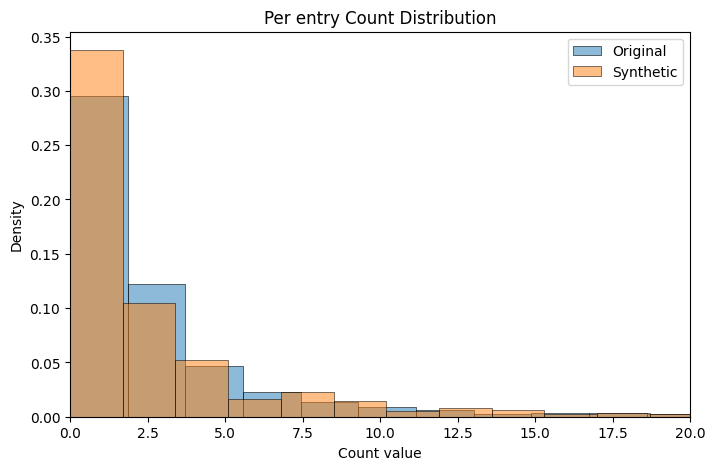

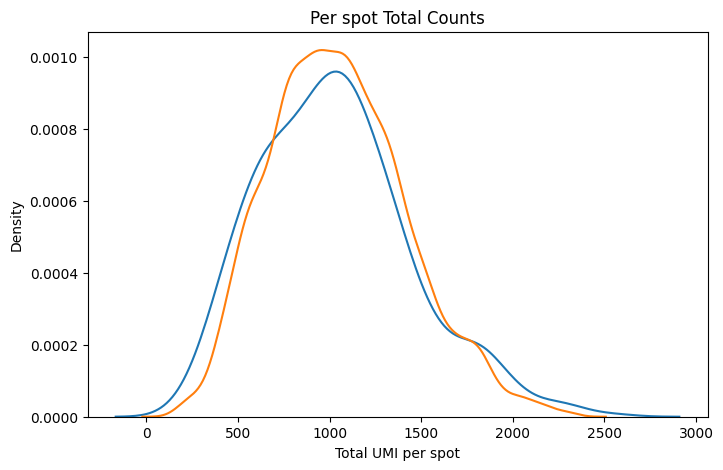

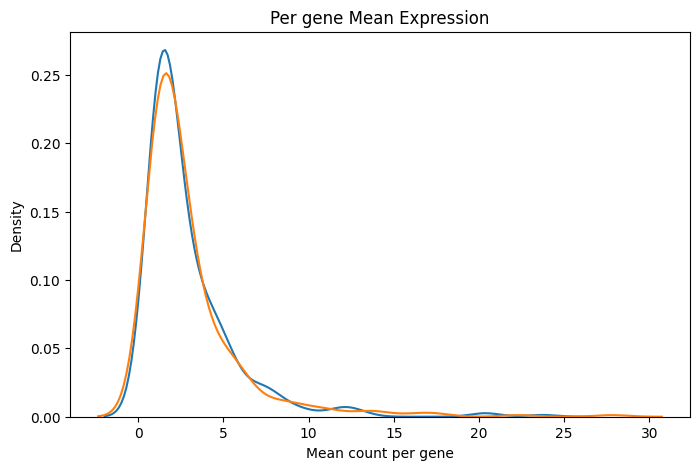

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Flattened count histograms
orig_vals  = X_umi.flatten()
synth_vals = X_synth.flatten()

plt.figure(figsize=(8,5))
sns.histplot(orig_vals,  bins=100, color='C0', label='Original', stat='density', alpha=0.5)
sns.histplot(synth_vals, bins=100, color='C1', label='Synthetic', stat='density', alpha=0.5)
plt.xlim(0, 20)            # zoom in on most common range
plt.ylim(0, None)
plt.legend()
plt.xlabel('Count value')
plt.ylabel('Density')
plt.title('Per entry Count Distribution')
plt.show()


# 2) Per‐spot total UMI counts
orig_totals  = X_umi.sum(axis=1)
synth_totals = X_synth.sum(axis=1)

plt.figure(figsize=(8,5))
sns.kdeplot(orig_totals,  label='Original',  color='C0')
sns.kdeplot(synth_totals, label='Synthetic', color='C1')
plt.xlabel('Total UMI per spot')
plt.ylabel('Density')
plt.title('Per spot Total Counts')
plt.show()


# 3) Per‐gene mean expression
orig_gene_means  = X_umi.mean(axis=0)
synth_gene_means = X_synth.mean(axis=0)

plt.figure(figsize=(8,5))
sns.kdeplot(orig_gene_means,  label='Original',  color='C0')
sns.kdeplot(synth_gene_means, label='Synthetic', color='C1')
plt.xlabel('Mean count per gene')
plt.ylabel('Density')
plt.title('Per gene Mean Expression')
plt.show()


In [9]:
X_all.flatten()

array([0., 1., 0., ..., 2., 5., 4.], dtype=float32)

In [64]:
coord_df

coord_x      coord_y                      celltype  is_synthetic
ST_12    1581.242732  1329.313864  Forebrain/Midbrain/Hindbrain         False
ST_13    1586.662026  1329.313864  Forebrain/Midbrain/Hindbrain         False
ST_42    1581.242732  1334.863919  Forebrain/Midbrain/Hindbrain         False
ST_43    1586.662026  1334.863919  Forebrain/Midbrain/Hindbrain         False
ST_49    1619.177788  1334.863919                   Endothelium         False
...              ...          ...                           ...           ...
ST_1182  1581.242732  1545.766004  Forebrain/Midbrain/Hindbrain         False
ST_1183  1586.662026  1545.766004  Forebrain/Midbrain/Hindbrain         False
ST_1184  1592.081319  1545.766004                  Dermomyotome         False
ST_1185  1597.500613  1545.766004                  Dermomyotome         False
ST_1186  1602.919907  1545.766004                  Dermomyotome         False

[581 rows x 4 columns]

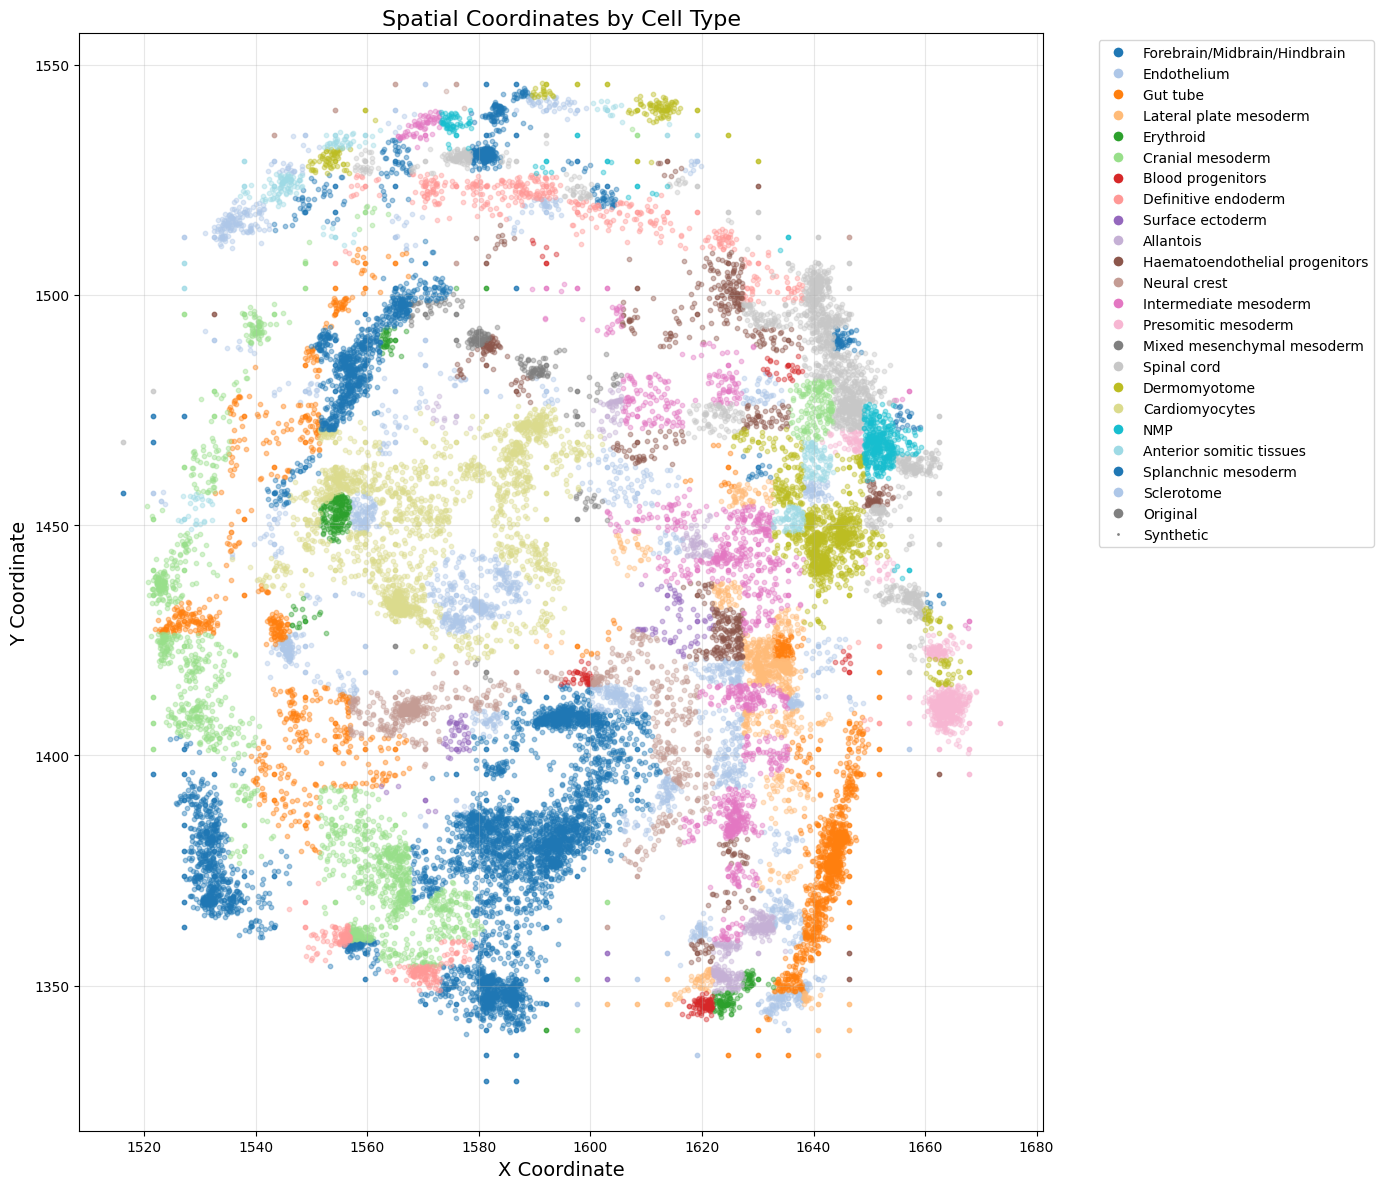

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

def plot_original_and_synthetic_data(real_coords, real_celltypes, synth_coords=None, synth_expressions=None):
    """
    Plot original and synthetic spatial transcriptomics data.
    
    Parameters:
    -----------
    real_coords : np.ndarray
        Array of shape (n_real, 2) with original coordinates
    real_celltypes : np.ndarray or list
        Cell type labels for original points
    synth_coords : np.ndarray or None
        Array of shape (n_synth, 2) with synthetic coordinates
    synth_expressions : np.ndarray or None
        Array with synthetic gene expressions
    """
    # Create DataFrame for original points
    coord_df = pd.DataFrame({
        'coord_x': real_coords[:, 0],
        'coord_y': real_coords[:, 1],
        'celltype': real_celltypes,
        'is_synthetic': False
    })
    
    # Check if synthetic data exists
    if synth_coords is not None and len(synth_coords) > 0:
        # Make sure synth_coords is properly formatted
        if isinstance(synth_coords, list):
            synth_coords = np.array(synth_coords)
        
        # Reshape if needed
        if synth_coords.ndim == 1:
            synth_coords = synth_coords.reshape(-1, 2)
            
        # Assign cell types to synthetic points based on nearest neighbor
        nn_model = NearestNeighbors(n_neighbors=1)
        nn_model.fit(real_coords)
        
        # Find nearest original point for each synthetic point
        distances, indices = nn_model.kneighbors(synth_coords)
        
        # Assign the cell type of the nearest original point
        synth_celltypes = [real_celltypes[idx] for idx in indices.flatten()]
        
        # Create DataFrame for synthetic points
        synth_df = pd.DataFrame({
            'coord_x': synth_coords[:, 0],
            'coord_y': synth_coords[:, 1],
            'celltype': synth_celltypes,
            'is_synthetic': True
        })
        
        # Combine original and synthetic data
        combined_df = pd.concat([coord_df, synth_df], ignore_index=True)
    else:
        # Just use original data
        combined_df = coord_df
        print("Warning: No synthetic data provided or synthetic data is empty.")
    
    # Get unique cell types for coloring
    unique_celltypes = combined_df['celltype'].unique()
    
    # Create a custom colormap
    num_colors = len(unique_celltypes)
    palette = sns.color_palette('tab20', n_colors=num_colors)
    celltype_to_color = {celltype: palette[i] for i, celltype in enumerate(unique_celltypes)}
    
    # Create the plot
    plt.figure(figsize=(14, 12))
    
    # Plot by cell type with different markers for original/synthetic
    for celltype in unique_celltypes:
        # Original points
        orig_subset = combined_df[(combined_df['celltype'] == celltype) & 
                                 (~combined_df['is_synthetic'])]
        if len(orig_subset) > 0:
            plt.scatter(orig_subset['coord_x'], orig_subset['coord_y'],
                       color=celltype_to_color[celltype],
                       marker='o',  # Circle marker
                       s=10,
                       alpha=0.8)
        
        # Synthetic points (only if we have any)
        synth_subset = combined_df[(combined_df['celltype'] == celltype) & 
                                  (combined_df['is_synthetic'])]
        if len(synth_subset) > 0:
            plt.scatter(synth_subset['coord_x'], synth_subset['coord_y'],
                       color=celltype_to_color[celltype],
                       marker='o',  # Smaller dot marker
                       s=10,
                       alpha=0.4)
    
    # Add a legend
    legend_elements = []
    for celltype in unique_celltypes:
        from matplotlib.lines import Line2D
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor=celltype_to_color[celltype],
                   markersize=8, label=celltype)
        )
    
    # Add original/synthetic markers to legend
    legend_elements.append(
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markersize=8, label='Original')
    )
    if 'synth_df' in locals():
        legend_elements.append(
            Line2D([0], [0], marker='.', color='w', markerfacecolor='gray',
                   markersize=6, label='Synthetic')
        )
    
    plt.legend(handles=legend_elements, 
               bbox_to_anchor=(1.05, 1), 
               loc='upper left', 
               fontsize=10)
    
    plt.title('Spatial Coordinates by Cell Type', fontsize=16)
    plt.xlabel('X Coordinate', fontsize=14)
    plt.ylabel('Y Coordinate', fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()  # Return the figure for further customization if needed

# Example usage:
plot_original_and_synthetic_data(real_coords, dominant_celltypes, coords_synth_filtered)
# plt.savefig('spatial_plot.png', dpi=300)
plt.show()

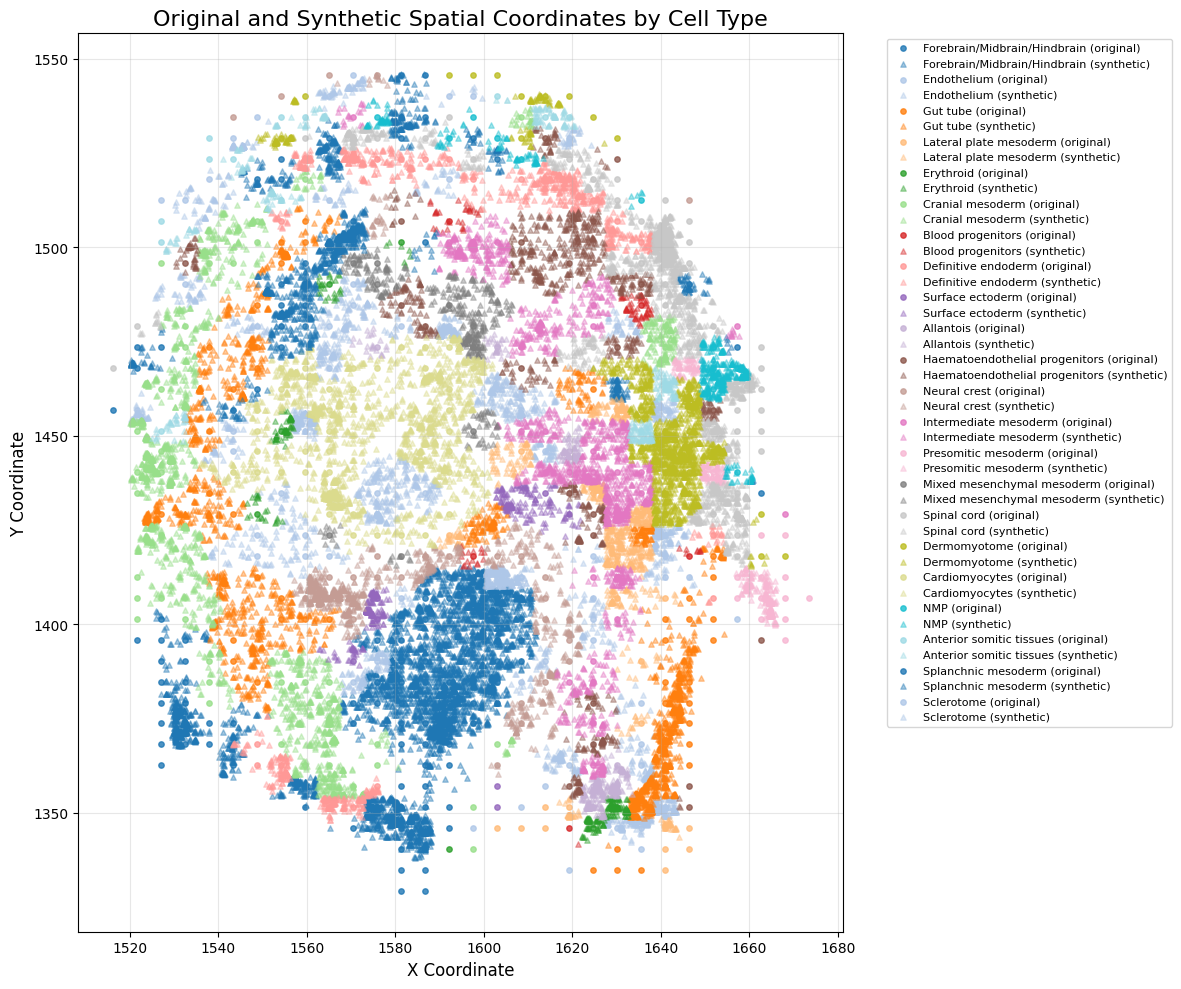

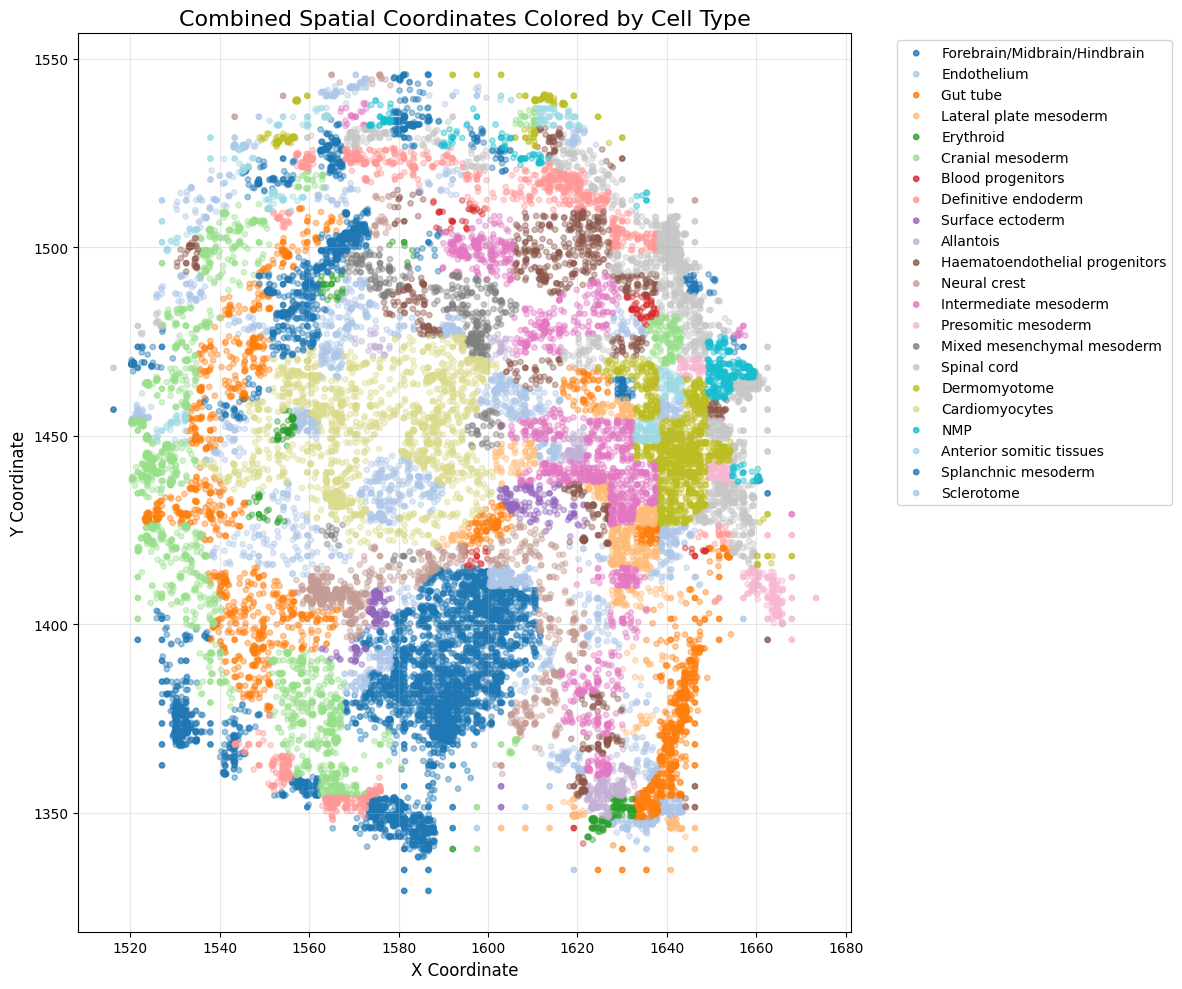

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Assuming you have the following variables already defined:
# - coords_synth: numpy array of synthetic coordinates
# - X_synth: numpy array of synthetic gene expressions
# - coord_df: DataFrame with original coordinates and cell types

# Step 1: Determine cell types for synthetic points
# We need to assign cell types to the synthetic points based on nearest neighbor
from sklearn.neighbors import NearestNeighbors

# Fit nearest neighbors model on original data
nn_model = NearestNeighbors(n_neighbors=1)
nn_model.fit(coord_df[['coord_x', 'coord_y']].values)

# Find nearest original point for each synthetic point
distances, indices = nn_model.kneighbors(coords_synth)

# Assign the cell type of the nearest original point
synth_celltypes = [coord_df['celltype'].iloc[idx] for idx in indices.flatten()]

# Step 2: Create a DataFrame for synthetic points
synth_df = pd.DataFrame({
    'coord_x': coords_synth[:, 0],
    'coord_y': coords_synth[:, 1],
    'celltype': synth_celltypes,
    'is_synthetic': True  # Add flag to distinguish synthetic points
})

# Add flag to original data
coord_df['is_synthetic'] = False

# Step 3: Combine original and synthetic data
combined_df = pd.concat([coord_df, synth_df], ignore_index=True)

# Step 4: Plot with different markers for original vs synthetic
plt.figure(figsize=(12, 10))

# Get unique cell types for coloring
unique_celltypes = combined_df['celltype'].unique()

# Create a custom colormap
num_colors = len(unique_celltypes)
palette = sns.color_palette('tab20', n_colors=num_colors)
celltype_to_color = {celltype: palette[i] for i, celltype in enumerate(unique_celltypes)}

# Plot each cell type with a different color
# Original points as circles, synthetic as triangles
for celltype in unique_celltypes:
    # Original points (circles)
    orig_subset = combined_df[(combined_df['celltype'] == celltype) & (~combined_df['is_synthetic'])]
    if len(orig_subset) > 0:
        plt.scatter(orig_subset['coord_x'], orig_subset['coord_y'],
                   color=celltype_to_color[celltype],
                   marker='o',  # Circle marker
                   s=15,
                   label=f"{celltype} (original)",
                   alpha=0.8)
    
    # Synthetic points (triangles)
    synth_subset = combined_df[(combined_df['celltype'] == celltype) & (combined_df['is_synthetic'])]
    if len(synth_subset) > 0:
        plt.scatter(synth_subset['coord_x'], synth_subset['coord_y'],
                   color=celltype_to_color[celltype],
                   marker='^',  # Triangle marker
                   s=15,
                   label=f"{celltype} (synthetic)",
                   alpha=0.4)

# Alternative: Plot all original points in one color, synthetic in another
plt.title('Original and Synthetic Spatial Coordinates by Cell Type', fontsize=16)
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.grid(alpha=0.3)

# Create a custom legend with unique entries only
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left', 
           fontsize=8)

plt.tight_layout()
plt.show()

# Optional: For a cleaner plot, you might want to show only cell types without distinguishing original/synthetic
plt.figure(figsize=(12, 10))

# Plot each cell type with a different color, but now with different alpha for original vs synthetic
for celltype in unique_celltypes:
    # Get both original and synthetic points for this cell type
    subset = combined_df[combined_df['celltype'] == celltype]
    
    # Plot all points of this cell type with the same color but different transparency
    plt.scatter(subset['coord_x'], subset['coord_y'],
               color=celltype_to_color[celltype],
               s=subset['is_synthetic'].map({False: 15, True: 15}),  # Different size
               alpha=subset['is_synthetic'].map({False: 0.8, True: 0.4}),  # Different transparency
               label=celltype)

plt.title('Combined Spatial Coordinates Colored by Cell Type', fontsize=16)
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

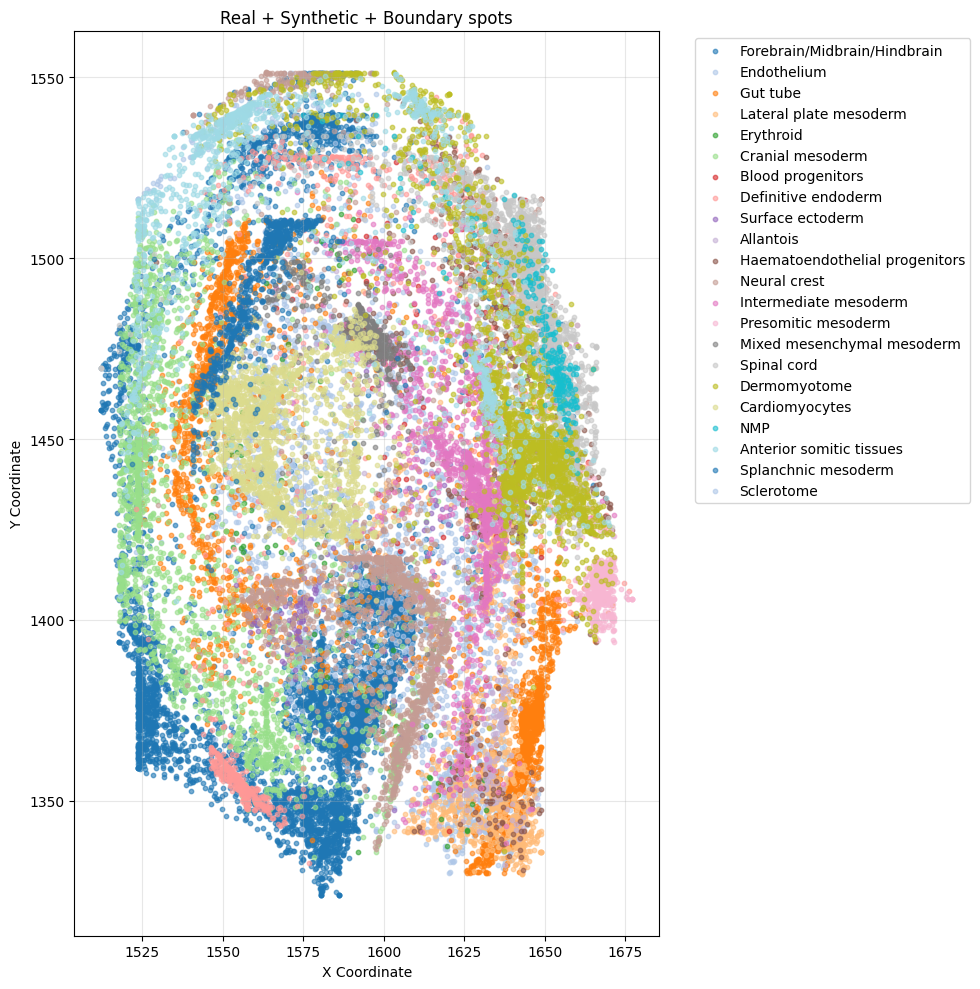

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

# ———————————————————————————————
# 1) Your real data (already in memory)
#    coords          : np.ndarray, shape (N_real, 2)
#    z_orig          : np.ndarray, shape (N_real, latent_dim)
#    dominant_celltypes : list or array of length N_real
#    z_syn           : np.ndarray, shape (N_synth, latent_dim)
#    X_synth         : your synthetic counts (not needed here for plotting)
# ———————————————————————————————

coords_real = coords.copy()
feats_real  = z_orig.copy()
labels_real = np.array(dominant_celltypes)

# ———————————————————————————————
# 2)  Re-interpolate your synthetic latents → coords
knn_feat = NearestNeighbors(n_neighbors=5).fit(feats_real)
dists, idxs = knn_feat.kneighbors(z_syn)            # (N_synth,5)

# spiky Dirichlet weights to hug single neighbors
alpha = 0.3
w = np.random.dirichlet([alpha]*5, size=len(z_syn))  # (N_synth,5)

# coords_real[idxs] shape = (N_synth,5,2), multiply & sum to get (N_synth,2)
coords_synth_knn = (coords_real[idxs] * w[:,:,None]).sum(axis=1)

# label those synth points
knn_clf = KNeighborsClassifier(n_neighbors=5).fit(feats_real, labels_real)
labels_synth_knn = knn_clf.predict(z_syn)

# ———————————————————————————————
# 3)  Build boundary‐boost points
hull = ConvexHull(coords_real)
center = coords_real.mean(axis=0)

bidx = hull.vertices
coords_boundary = []
labels_boundary = []
for i in bidx:
    lab = labels_real[i]
    base = coords_real[i]
    direction = base - center
    direction /= np.linalg.norm(direction)
    for _ in range(3):  # pick 3 jittered extras per hull vertex
        pt = base + 0.02 * direction * np.random.rand()
        coords_boundary.append(pt)
        labels_boundary.append(lab)

coords_boundary = np.vstack(coords_boundary)      # (N_bound,2)
labels_boundary = np.array(labels_boundary)       # (N_bound,)

# ———————————————————————————————
# 4)  Radial expansion (optional, for more whitespace)
all_coords = np.vstack([coords_real, coords_synth_knn, coords_boundary])
c0 = all_coords.mean(axis=0)
scale = 1.05
all_coords = (all_coords - c0)*scale + c0

# 5)  Stack labels in the same order
all_labels = np.concatenate([
    labels_real,            # (N_real,)
    labels_synth_knn,       # (N_synth,)
    labels_boundary         # (N_bound,)
])

# Sanity check
assert all_coords.shape[0] == all_labels.shape[0], \
    f"Coords ({all_coords.shape[0]}) vs labels ({all_labels.shape[0]})"

# ———————————————————————————————
# 6)  Build DataFrame & plot
df = pd.DataFrame(all_coords, columns=['coord_x','coord_y'])
df['celltype'] = all_labels

plt.figure(figsize=(10,10))
uniq = df['celltype'].unique()
palette = sns.color_palette('tab20', n_colors=len(uniq))
colmap = {ct: palette[i] for i, ct in enumerate(uniq)}

for ct in uniq:
    sub = df[df['celltype']==ct]
    plt.scatter(sub['coord_x'], sub['coord_y'],
                color=colmap[ct], label=ct, s=10, alpha=0.6)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.xlabel('X Coordinate'); plt.ylabel('Y Coordinate')
plt.title('Real + Synthetic + Boundary spots')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [52]:
from scipy.spatial import Delaunay

tri = Delaunay(real_coords)

In [53]:
tri

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# 1) Prepare your real features + labels
#    You already have `dominant_celltypes` for your real spots in the same order as X_umi (or X_log), 
#    so let’s use the latent embeddings z_orig (N×latent_dim) as “features”:
real_feats = z_orig                   # shape (N_real, latent_dim)
real_labels = np.array(dominant_celltypes)

# 2) Fit a little KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(real_feats, real_labels)

# 3) Extract synthetic embeddings (z_syn) from your NB-VAE
#    (you already did this when generating coords_synth)
#    shape is (N_synth, latent_dim)
syn_feats = z_syn

# 4) Predict synthetic labels
syn_labels = knn.predict(syn_feats)  # array of length N_synth

# 5) Build a combined obs dataframe for plotting
aug_coord_df = pd.DataFrame(
    np.vstack([coords, coords_synth]), 
    columns=['coord_x','coord_y']
)
aug_coord_df['celltype'] = np.concatenate([real_labels, syn_labels])

# 6) Now plot *exactly* as before:
plt.figure(figsize=(10,10))
unique_ct = aug_coord_df['celltype'].unique()
palette = sns.color_palette('tab20', n_colors=len(unique_ct))
c2c = {ct:palette[i] for i,ct in enumerate(unique_ct)}

for ct in unique_ct:
    sub = aug_coord_df[aug_coord_df['celltype']==ct]
    plt.scatter(sub['coord_x'], sub['coord_y'],
                color=c2c[ct], label=ct, s=10, alpha=0.6)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.xlabel('X Coordinate'); plt.ylabel('Y Coordinate')
plt.title('Real + Synthetic spots colored by KNN‐assigned celltype')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


ValueError: Length of values (23821) does not match length of index (23872)

In [27]:
len(coords_synth)

23291

In [12]:
print("coords shape:      ", coords.shape)
print("coords_synth shape:", np.array(coords_synth).shape)
print("real_labels len:   ", len(real_labels))
print("syn_labels len:    ", len(syn_labels))
print("DF rows:           ", aug_coord_df.shape[0])


coords shape:       (581, 2)
coords_synth shape: (51, 2)
real_labels len:    581
syn_labels len:     23240
DF rows:            632


In [27]:
coords_synth

array([[4.26493854e+18, 3.84191002e+18],
       [4.26493854e+18, 3.84191002e+18],
       [4.26493854e+18, 3.84191002e+18],
       ...,
       [4.26493854e+18, 3.84191002e+18],
       [4.26493854e+18, 3.84191002e+18],
       [4.26493854e+18, 3.84191002e+18]])

In [1]:
bidx

NameError: name 'bidx' is not defined

In [46]:
hull

In [51]:
boundary_idxs

array([ 62,   0,   1,   8,  16, 214, 421, 507, 572, 580, 573, 550, 534,
       499, 386, 356, 157], dtype=int32)